# Credit Card Users Churn Prediction

## Problem Statement

### Business Context

The Thera bank recently saw a steep decline in the number of users of their credit card, credit cards are a good source of income for banks because of different kinds of fees charged by the banks like annual fees, balance transfer fees, and cash advance fees, late payment fees, foreign transaction fees, and others. Some fees are charged to every user irrespective of usage, while others are charged under specified circumstances.

Customers’ leaving credit cards services would lead bank to loss, so the bank wants to analyze the data of customers and identify the customers who will leave their credit card services and reason for same – so that bank could improve upon those areas

You as a Data scientist at Thera bank need to come up with a classification model that will help the bank improve its services so that customers do not renounce their credit cards

### Data Description

* CLIENTNUM: Client number. Unique identifier for the customer holding the account
* Attrition_Flag: Internal event (customer activity) variable - if the account is closed then "Attrited Customer" else "Existing Customer"
* Customer_Age: Age in Years
* Gender: Gender of the account holder
* Dependent_count: Number of dependents
* Education_Level: Educational Qualification of the account holder - Graduate, High School, Unknown, Uneducated, College(refers to college student), Post-Graduate, Doctorate
* Marital_Status: Marital Status of the account holder
* Income_Category: Annual Income Category of the account holder
* Card_Category: Type of Card
* Months_on_book: Period of relationship with the bank (in months)
* Total_Relationship_Count: Total no. of products held by the customer
* Months_Inactive_12_mon: No. of months inactive in the last 12 months
* Contacts_Count_12_mon: No. of Contacts in the last 12 months
* Credit_Limit: Credit Limit on the Credit Card
* Total_Revolving_Bal: Total Revolving Balance on the Credit Card
* Avg_Open_To_Buy: Open to Buy Credit Line (Average of last 12 months)
* Total_Amt_Chng_Q4_Q1: Change in Transaction Amount (Q4 over Q1)
* Total_Trans_Amt: Total Transaction Amount (Last 12 months)
* Total_Trans_Ct: Total Transaction Count (Last 12 months)
* Total_Ct_Chng_Q4_Q1: Change in Transaction Count (Q4 over Q1)
* Avg_Utilization_Ratio: Average Card Utilization Ratio

#### What Is a Revolving Balance?

- If we don't pay the balance of the revolving credit account in full every month, the unpaid portion carries over to the next month. That's called a revolving balance


##### What is the Average Open to buy?

- 'Open to Buy' means the amount left on your credit card to use. Now, this column represents the average of this value for the last 12 months.

##### What is the Average utilization Ratio?

- The Avg_Utilization_Ratio represents how much of the available credit the customer spent. This is useful for calculating credit scores.


##### Relation b/w Avg_Open_To_Buy, Credit_Limit and Avg_Utilization_Ratio:

- ( Avg_Open_To_Buy / Credit_Limit ) + Avg_Utilization_Ratio = 1

## Importing necessary libraries

In [487]:
# Data manipulation and analysis.
import pandas as pd
import numpy as np

# Data visualization libraries.
import matplotlib.pyplot as plt
import seaborn as sns

# Model tuning and metrics.
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
)

#For splitting model data into train, validation and test.
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# Data preparation.
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# Data imputation.
from sklearn.impute import SimpleImputer
from sklearn import metrics

# For over and undersampling.
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# For hyperparameter tuning.
from sklearn.model_selection import RandomizedSearchCV

# Models builders.
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

#OPTIONS
#--------------------------------------------------------------------
# Define maximum number of columns to be displayed in a dataframe.
pd.set_option("display.max_columns", None)

# Supress scientific notations for a dataframe.
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# Supress warnings.
import warnings
warnings.filterwarnings("ignore")

## Define Functions

#### EDA Functions

In [488]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [489]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [490]:
# function to plot stacked bar chart

def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [491]:
### Function to plot distributions

def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

#Pre-processing Functions

In [492]:
def outlier_detection(data):
  Q1 = data.quantile(0.25)  # To find the 25th percentile
  Q3 = data.quantile(0.75)  # To find the 75th percentile

  IQR = Q3 - Q1  # Inter Quantile Range (75th perentile - 25th percentile)

  # Finding lower and upper bounds for all values. All values outside these bounds are outliers
  lower = (Q1 - 1.5 * IQR)
  upper = (Q3 + 1.5 * IQR)

  # checking the % outliers
  print(((data.select_dtypes(include=["float64", "int64"]) < lower) | (data.select_dtypes(include=["float64", "int64"]) > upper)).sum() / len(data) * 100)

In [493]:
## Function to inverse encoding
def inverse_mapping(x, y):
    inv_dict = {v: k for k, v in x.items()}
    X_train[y] = np.round(X_train[y]).map(inv_dict).astype("category")
    X_val[y] = np.round(X_val[y]).map(inv_dict).astype("category")
    X_test[y] = np.round(X_test[y]).map(inv_dict).astype("category")

# Model Performance Metrics

In [494]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1

        },
        index=[0],
    )

    return df_perf

## Loading the dataset

In [495]:
# Connect to google drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [496]:
# Load the csv file into the dataframe.
churn_df = pd.read_csv("/content/drive/My Drive/colab-notebooks/credit-card-churn-prediction/BankChurners.csv")

In [497]:
# Copy into a new dataframe.
df = churn_df.copy()

## Data Overview

### Display First and Last Rows

In [498]:
# First five rows
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.000,777,11914.000,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.000,864,7392.000,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.000,0,3418.000,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,NaN,Less than $40K,Blue,34,3,4,1,3313.000,2517,796.000,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.000,0,4716.000,2.175,816,28,2.500,0.000


In [499]:
# Last five rows
df.tail()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
10122,772366833,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,2,3,4003.000,1851,2152.000,0.703,15476,117,0.857,0.462
10123,710638233,Attrited Customer,41,M,2,NaN,Divorced,$40K - $60K,Blue,25,4,2,3,4277.000,2186,2091.000,0.804,8764,69,0.683,0.511
10124,716506083,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,5,3,4,5409.000,0,5409.000,0.819,10291,60,0.818,0.000
10125,717406983,Attrited Customer,30,M,2,Graduate,NaN,$40K - $60K,Blue,36,4,3,3,5281.000,0,5281.000,0.535,8395,62,0.722,0.000
10126,714337233,Attrited Customer,43,F,2,Graduate,Married,Less than $40K,Silver,25,6,2,4,10388.000,1961,8427.000,0.703,10294,61,0.649,0.189


#### Observations
* Education_Level and Marital_Status have Nan values
* Several catergories of string which will need to be treated.

### Data Summary

In [500]:
# Data Summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           8608 non-null   object 
 6   Marital_Status            9378 non-null   object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

#### Observations
* Object data types will need to be transformed to numeric.
* There are missing values in Education_Level and Marital_Status

### Duplicates and Nulls

In [501]:
# Check for duplicate rows.
df.duplicated().sum()

0

In [502]:
# Check for null values.
round(df.isnull().sum() / df.isnull().count() * 100, 2)

CLIENTNUM                   0.000
Attrition_Flag              0.000
Customer_Age                0.000
Gender                      0.000
Dependent_count             0.000
Education_Level            15.000
Marital_Status              7.400
Income_Category             0.000
Card_Category               0.000
Months_on_book              0.000
Total_Relationship_Count    0.000
Months_Inactive_12_mon      0.000
Contacts_Count_12_mon       0.000
Credit_Limit                0.000
Total_Revolving_Bal         0.000
Avg_Open_To_Buy             0.000
Total_Amt_Chng_Q4_Q1        0.000
Total_Trans_Amt             0.000
Total_Trans_Ct              0.000
Total_Ct_Chng_Q4_Q1         0.000
Avg_Utilization_Ratio       0.000
dtype: float64

#### Observations
* There is no duplicate data
* 15% of Education_Level are unknown values
* 7.4% if Marital_Status are unknown values

### Column Value Analysis

In [503]:
# get columns
cat_col = df.columns

# Occurrences of each unique value in each categorical column sorted by most frequent
for column in cat_col:
    print(df[column].value_counts(normalize=True, sort=True))
    print("-" * 50)

768805383   0.000
711784908   0.000
720133908   0.000
803197833   0.000
812222208   0.000
             ... 
796903083   0.000
716014983   0.000
712521783   0.000
780045708   0.000
714337233   0.000
Name: CLIENTNUM, Length: 10127, dtype: float64
--------------------------------------------------
Existing Customer   0.839
Attrited Customer   0.161
Name: Attrition_Flag, dtype: float64
--------------------------------------------------
44   0.049
49   0.049
46   0.048
45   0.048
47   0.047
43   0.047
48   0.047
50   0.045
42   0.042
51   0.039
53   0.038
41   0.037
52   0.037
40   0.036
39   0.033
54   0.030
38   0.030
55   0.028
56   0.026
37   0.026
57   0.022
36   0.022
35   0.018
59   0.016
58   0.016
34   0.014
33   0.013
60   0.013
32   0.010
65   0.010
61   0.009
62   0.009
31   0.009
26   0.008
30   0.007
63   0.006
29   0.006
64   0.004
27   0.003
28   0.003
67   0.000
66   0.000
68   0.000
70   0.000
73   0.000
Name: Customer_Age, dtype: float64
----------------------------------

In [504]:
# Look at strings only.
df.describe(include=['object']).T

,count,unique,top,freq
Attrition_Flag,10127,2,Existing Customer,8500
Gender,10127,2,F,5358
Education_Level,8608,6,Graduate,3128
Marital_Status,9378,3,Married,4687
Income_Category,10127,6,Less than $40K,3561
Card_Category,10127,4,Blue,9436


In [505]:
# Look at numeric data types.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CLIENTNUM,10127.000,739177606.334,36903783.450,708082083.000,713036770.500,717926358.000,773143533.000,828343083.000
Customer_Age,10127.000,46.326,8.017,26.000,41.000,46.000,52.000,73.000
Dependent_count,10127.000,2.346,1.299,0.000,1.000,2.000,3.000,5.000
Months_on_book,10127.000,35.928,7.986,13.000,31.000,36.000,40.000,56.000
Total_Relationship_Count,10127.000,3.813,1.554,1.000,3.000,4.000,5.000,6.000
Months_Inactive_12_mon,10127.000,2.341,1.011,0.000,2.000,2.000,3.000,6.000
Contacts_Count_12_mon,10127.000,2.455,1.106,0.000,2.000,2.000,3.000,6.000
Credit_Limit,10127.000,8631.954,9088.777,1438.300,2555.000,4549.000,11067.500,34516.000
Total_Revolving_Bal,10127.000,1162.814,814.987,0.000,359.000,1276.000,1784.000,2517.000
Avg_Open_To_Buy,10127.000,7469.140,9090.685,3.000,1324.500,3474.000,9859.000,34516.000


#### Observations
* Attrition_Flag (dependent variable)
  * 85% of the data are existing customers
  * 16% of the data are customers which have attritioned
* 94% of card holders are in the "Blue" category

### **Data Overview Observations**
* Attrition_Flag is our dependent variable
  * Existing customers are the majority class at 84%.
  * Attritioned customers are the minority class at 16%

    **Oversampling and undersampling should be considered**

* Columns which will need treatment
  * Object (string) data types will be changed to category (numeric)
    * Attrition_Flag
    * Gender
    * Education_Level
    * Marital_Status
    * Income_Category
    * Card_Category
* There are no duplicate rows
* 15% of values under Education_Level are NaN and will need to be treated
* 7.4% of values under Marital_Status are NaN and will been to be treated
* Income_Category will need to be ordered

## <a name="eda_summary"></a>Exploratory Data Analysis (EDA)

<a href=#eda_appendix>Click to see full analysis</a>

### Exploratory Data Analysis Questions and Observations

**Questions**:

1. How is the total transaction amount distributed?

* Existing Customers
  * Distribution is multi-modal with an increase in transactions at around 39 and 79.

* Attrited Customers
  * Distribution is more symmetrical with the most transactions between 40 and 43.

**Overall, attritioned customers have less credit card transactions.**



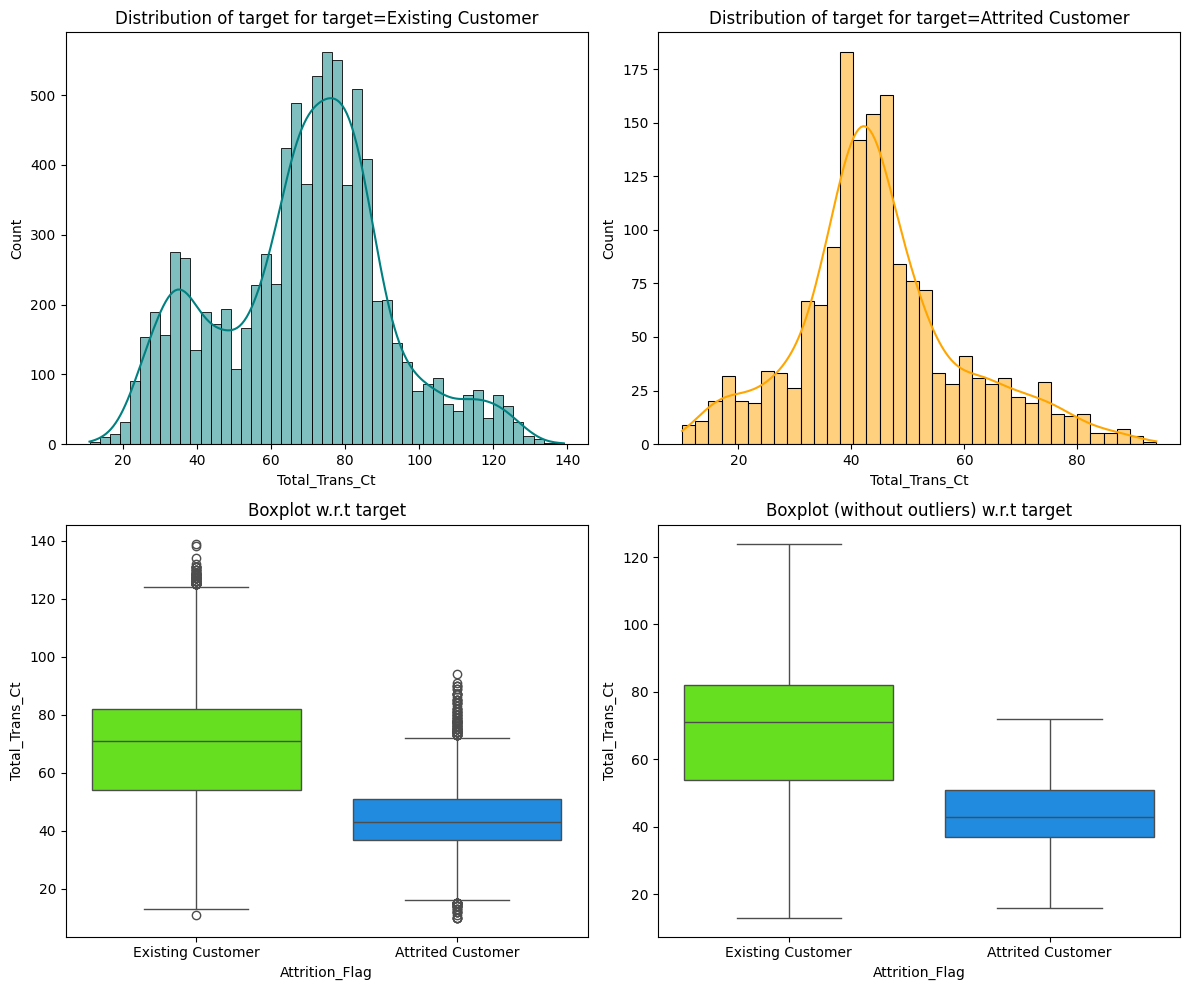

In [506]:
distribution_plot_wrt_target(df, "Total_Trans_Ct", "Attrition_Flag")

2. What is the distribution of the level of education of customers?

* The largest percentage of attritioned customers are either highly-educated (Doctorate, Post-Graduate) or uneducated.
* For each education level the attrition rate is between 15% and 20%.

Attrition_Flag   Attrited Customer  Existing Customer   All
Education_Level                                            
All                           1371               7237  8608
Graduate                       487               2641  3128
High School                    306               1707  2013
Uneducated                     237               1250  1487
College                        154                859  1013
Doctorate                       95                356   451
Post-Graduate                   92                424   516
------------------------------------------------------------------------------------------------------------------------


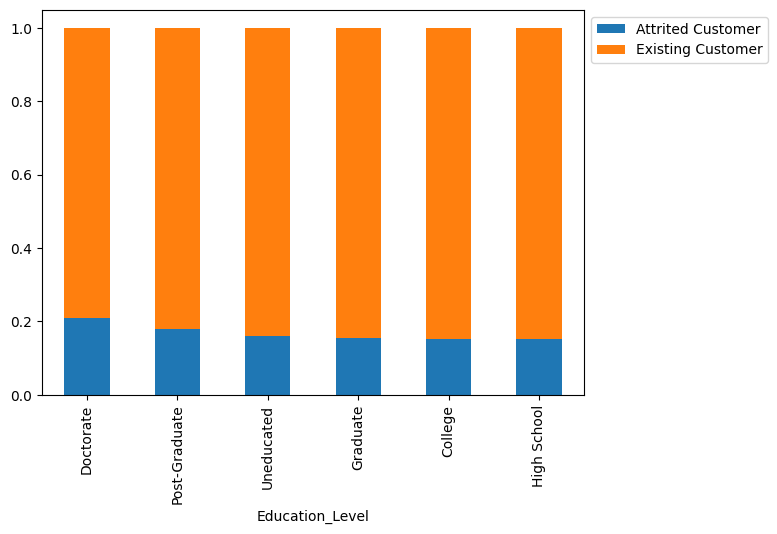

In [507]:
stacked_barplot(df, "Education_Level", "Attrition_Flag")

3. What is the distribution of the level of income of customers?

* The highest number of attritioned customers are making below 60k per year.
* However, by percentage it is between 15% and 18% roughly.

**Note: value 'abc' will be handled in pre-processing**


Attrition_Flag   Attrited Customer  Existing Customer    All
Income_Category                                             
All                           1627               8500  10127
Less than $40K                 612               2949   3561
$40K - $60K                    271               1519   1790
$80K - $120K                   242               1293   1535
$60K - $80K                    189               1213   1402
abc                            187                925   1112
$120K +                        126                601    727
------------------------------------------------------------------------------------------------------------------------


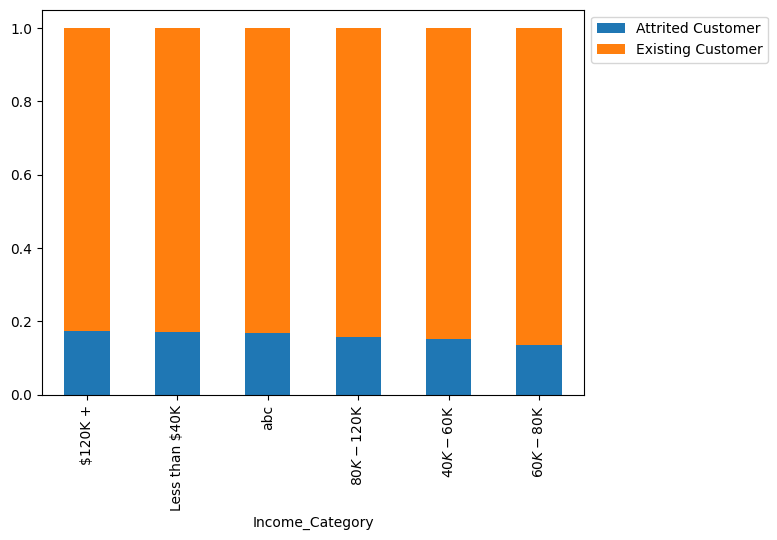

In [508]:
stacked_barplot(df, "Income_Category", "Attrition_Flag")

4. How does the change in transaction amount between Q4 and Q1 (`total_ct_change_Q4_Q1`) vary by the customer's account status (`Attrition_Flag`)?

* The number of transactions for attrited customers is less.
* The distribution of each is essentially a bell curve or symmetric.
* There are many more outliers for existing customers.

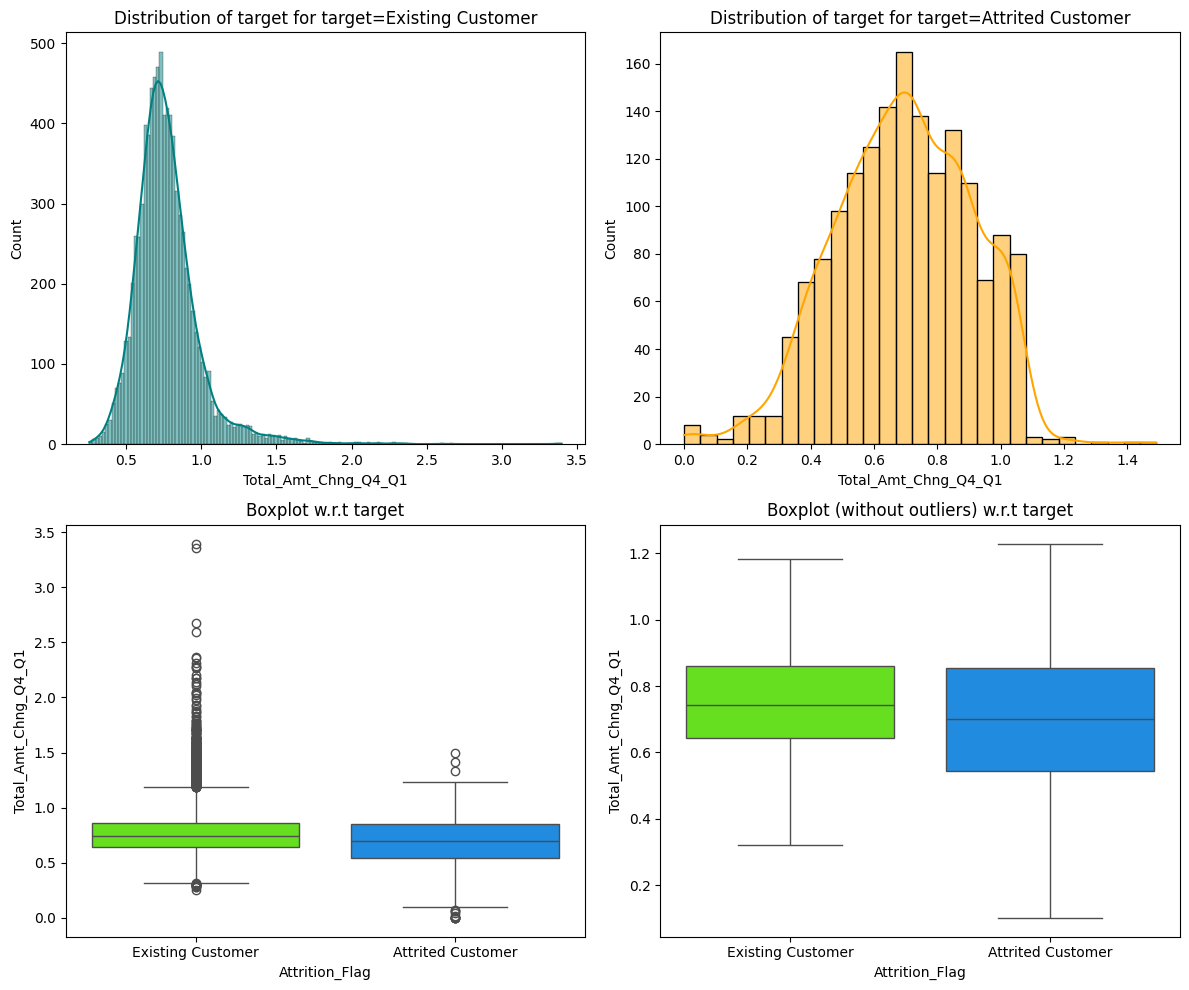

In [509]:
distribution_plot_wrt_target(df, "Total_Amt_Chng_Q4_Q1", "Attrition_Flag")

5. How does the number of months a customer was inactive in the last 12 months (`Months_Inactive_12_mon`) vary by the customer's account status (`Attrition_Flag`)?

* The most instance of attritioned customers are customers which have been inactive 2 or more months.
* The trend is as the number of months a customer is inactive increases their attrition rate increases.

Attrition_Flag          Attrited Customer  Existing Customer    All
Months_Inactive_12_mon                                             
All                                  1627               8500  10127
3                                     826               3020   3846
2                                     505               2777   3282
4                                     130                305    435
1                                     100               2133   2233
5                                      32                146    178
6                                      19                105    124
0                                      15                 14     29
------------------------------------------------------------------------------------------------------------------------


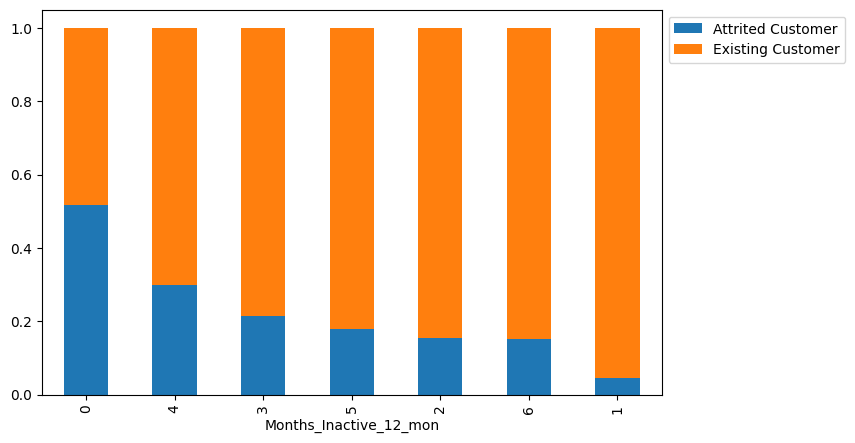

In [510]:
stacked_barplot(df, "Months_Inactive_12_mon", "Attrition_Flag")

6. What are the attributes that have a strong correlation with each other?

  * High positive correlations:
    * Customer_Age and Months_on_book
      * As a customer ages they have a longer relationship with the bank.
    * Total_Revolving_Balance and Avg_Utilization_Rate
      * As a customer utilizes their credit card more their balance rises.
    * Total_Trans_Ct and Total_Trans_Amt
      * As a customer performs more transaction with their card their balance rises.
  
* Negative Correlations
  * High Negative Correlation
    * Credit_Limit and Avg_Utilization_Ratio
      * As a customer's credit limit increases their utilization decreases.

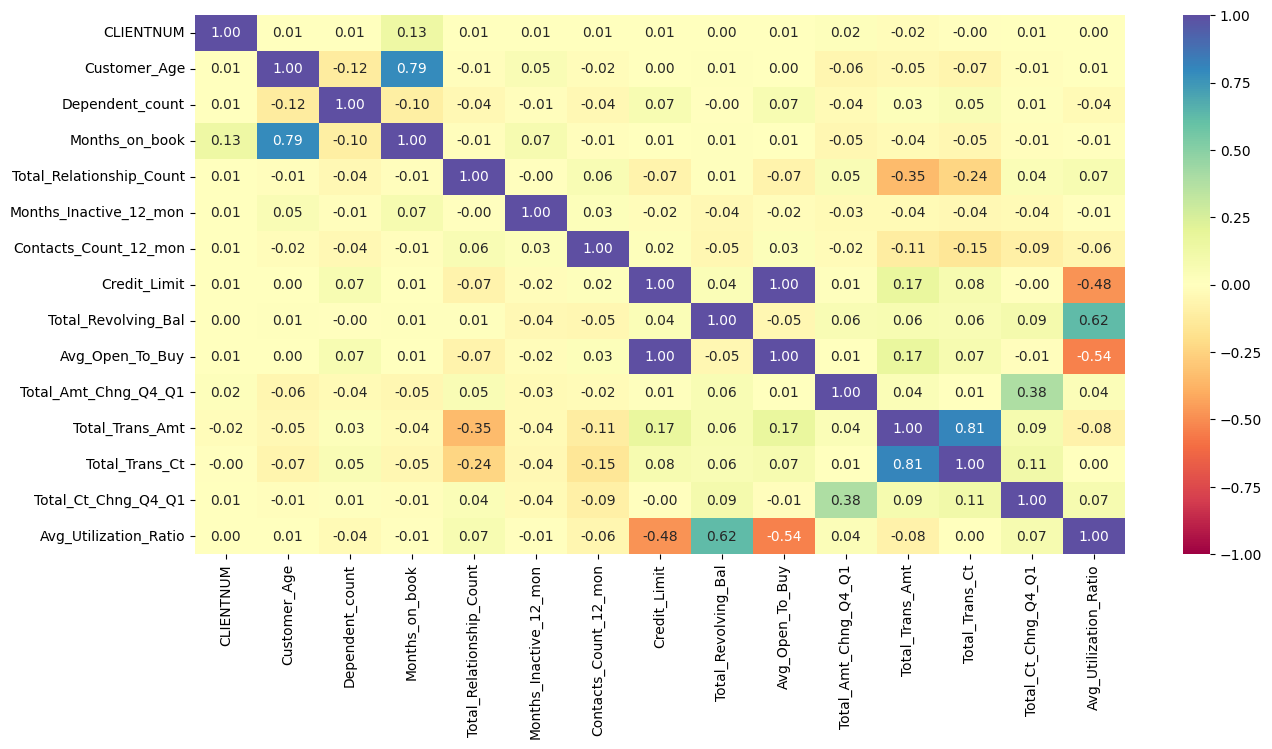

In [511]:
plt.figure(figsize=(15, 7))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

## Data Pre-processing

In [512]:
# Drop the clientnum as it is an ID column and not useful in the model.
df.drop('CLIENTNUM',axis=1, inplace=True)

In [513]:
# Find the percentage of outliers
outlier_detection(df)

Customer_Age               0.020
Dependent_count            0.000
Months_on_book             3.812
Total_Relationship_Count   0.000
Months_Inactive_12_mon     3.268
Contacts_Count_12_mon      6.211
Credit_Limit               9.717
Total_Revolving_Bal        0.000
Avg_Open_To_Buy            9.509
Total_Amt_Chng_Q4_Q1       3.910
Total_Trans_Amt            8.848
Total_Trans_Ct             0.020
Total_Ct_Chng_Q4_Q1        3.891
Avg_Utilization_Ratio      0.000
dtype: float64


In [514]:
# Handle Nan values
df["Income_Category"].replace("abc", np.nan, inplace=True)
df.isna().sum()

Attrition_Flag                 0
Customer_Age                   0
Gender                         0
Dependent_count                0
Education_Level             1519
Marital_Status               749
Income_Category             1112
Card_Category                  0
Months_on_book                 0
Total_Relationship_Count       0
Months_Inactive_12_mon         0
Contacts_Count_12_mon          0
Credit_Limit                   0
Total_Revolving_Bal            0
Avg_Open_To_Buy                0
Total_Amt_Chng_Q4_Q1           0
Total_Trans_Amt                0
Total_Trans_Ct                 0
Total_Ct_Chng_Q4_Q1            0
Avg_Utilization_Ratio          0
dtype: int64

## Missing value imputation




## Model Creation

In [515]:
# create X and y variables
X = df.drop(["Attrition_Flag"], axis=1)
y = df["Attrition_Flag"].apply(lambda x: 1 if x == "Attrited Customer" else 0)

In [516]:
# Splitting data into training, validation and test set:
# first we split data into 2 parts, say temporary and test

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

# then we split the temporary set into train and validation

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=1, stratify=y_temp
)
print(X_train.shape, X_val.shape, X_test.shape)

(6075, 19) (2026, 19) (2026, 19)


In [517]:
print("Number of rows in train data =", X_train.shape[0])
print("Number of rows in validation data =", X_val.shape[0])
print("Number of rows in test data =", X_test.shape[0])

Number of rows in train data = 6075
Number of rows in validation data = 2026
Number of rows in test data = 2026


In [518]:

# Get list of categorical and numerical columns
cat_cols = list(X_train.select_dtypes(include='object').columns)
num_cols = list(X_train.select_dtypes(include=['int', 'float']).columns)

# Impute categorical columns
cat_imputer = SimpleImputer(strategy='most_frequent')
X_train[cat_cols] = cat_imputer.fit_transform(X_train[cat_cols])
X_val[cat_cols] = cat_imputer.transform(X_val[cat_cols])
X_test[cat_cols] = cat_imputer.transform(X_test[cat_cols])

# Impute numerical columns
num_imputer = SimpleImputer(strategy='mean')
X_train[num_cols] = num_imputer.fit_transform(X_train[num_cols])
X_val[num_cols] = num_imputer.transform(X_val[num_cols])
X_test[num_cols] = num_imputer.transform(X_test[num_cols])

In [519]:
# Create numerical values for each categorical column
gender = {"M": 0, "F": 1}
X_train["Gender"] = X_train["Gender"].fillna(-1).map(gender)
X_val["Gender"] = X_val["Gender"].fillna(-1).map(gender)
X_test["Gender"] = X_test["Gender"].fillna(-1).map(gender)

education_level = {
    "Uneducated": 0,
    "High School": 1,
    "College": 2,
    "Graduate":3,
    "Post-Graduate": 4,
    "Doctorate": 5,
}
X_train["Education_Level"] = X_train["Education_Level"].fillna(-1).map(education_level)
X_val["Education_Level"] = X_val["Education_Level"].fillna(-1).map(education_level)
X_test["Education_Level"] = X_test["Education_Level"].fillna(-1).map(education_level)

marital_status = {
    "Single": 0,
    "Married": 1,
    "Divorced": 2
}
X_train["Marital_Status"] = X_train["Marital_Status"].fillna(-1).map(marital_status)
X_val["Marital_Status"] = X_val["Marital_Status"].fillna(-1).map(marital_status)
X_test["Marital_Status"] = X_test["Marital_Status"].fillna(-1).map(marital_status)

income_category = {
    'Less than $40K' : 0,
    '$40K - $60K' : 1,
    '$60K - $80K': 2,
    '$80K - $120K' : 3,
    '$120K +':4
}
X_train["Income_Category"] = X_train["Income_Category"].fillna(-1).map(income_category)
X_val["Income_Category"] = X_val["Income_Category"].fillna(-1).map(income_category)
X_test["Income_Category"] = X_test["Income_Category"].fillna(-1).map(income_category)

card_category = {
    "Blue": 0,
    "Silver": 1,
    "Gold": 2,
    "Platinum": 3
}
X_train["Card_Category"] = X_train["Card_Category"].fillna(-1).map(card_category)
X_val["Card_Category"] = X_val["Card_Category"].fillna(-1).map(card_category)
X_test["Card_Category"] = X_test["Card_Category"].fillna(-1).map(card_category)


In [520]:
# Checking that no column has missing values in train, validation or test sets
print(X_train.isna().sum())
print("-" * 30)
print(X_val.isna().sum())
print("-" * 30)

Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64
------------------------------
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal       

## Reverse Mapping for Encoded Variables


In [521]:
inverse_mapping(gender, "Gender")
inverse_mapping(education_level, "Education_Level")
inverse_mapping(marital_status, "Marital_Status")
inverse_mapping(income_category, "Income_Category")
inverse_mapping(card_category, "Card_Category")

## Train, Validate and Test Data

### Train

In [522]:
cols = X_train.select_dtypes(include=["object", "category"])
for i in cols.columns:
    print(X_train[i].value_counts())
    print("*" * 30)

F    3193
M    2882
Name: Gender, dtype: int64
******************************
Graduate         2782
High School      1228
Uneducated        881
College           618
Post-Graduate     312
Doctorate         254
Name: Education_Level, dtype: int64
******************************
Married     3276
Single      2369
Divorced     430
Name: Marital_Status, dtype: int64
******************************
Less than $40K    2783
$40K - $60K       1059
$80K - $120K       953
$60K - $80K        831
$120K +            449
Name: Income_Category, dtype: int64
******************************
Blue        5655
Silver       339
Gold          69
Platinum      12
Name: Card_Category, dtype: int64
******************************


### Validate

In [523]:
cols = X_val.select_dtypes(include=["object", "category"])
for i in cols.columns:
    print(X_val[i].value_counts())
    print("*" * 30)

F    1095
M     931
Name: Gender, dtype: int64
******************************
Graduate         917
High School      404
Uneducated       306
College          199
Post-Graduate    101
Doctorate         99
Name: Education_Level, dtype: int64
******************************
Married     1100
Single       770
Divorced     156
Name: Marital_Status, dtype: int64
******************************
Less than $40K    957
$40K - $60K       361
$80K - $120K      293
$60K - $80K       279
$120K +           136
Name: Income_Category, dtype: int64
******************************
Blue        1905
Silver        97
Gold          21
Platinum       3
Name: Card_Category, dtype: int64
******************************


### Test

In [524]:
cols = X_test.select_dtypes(include=["object", "category"])
for i in cols.columns:
    print(X_test[i].value_counts())
    print("*" * 30)

F    1070
M     956
Name: Gender, dtype: int64
******************************
Graduate         948
High School      381
Uneducated       300
College          196
Post-Graduate    103
Doctorate         98
Name: Education_Level, dtype: int64
******************************
Married     1060
Single       804
Divorced     162
Name: Marital_Status, dtype: int64
******************************
Less than $40K    933
$40K - $60K       370
$60K - $80K       292
$80K - $120K      289
$120K +           142
Name: Income_Category, dtype: int64
******************************
Blue        1876
Silver       119
Gold          26
Platinum       5
Name: Card_Category, dtype: int64
******************************


## Create Dummy Variable

In [525]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_val = pd.get_dummies(X_val, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)
print(X_train.shape, X_val.shape, X_test.shape)

(6075, 29) (2026, 29) (2026, 29)


## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model.
- False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

### Model Building with original data

Sample code for model building with original data

In [526]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("dtree", DecisionTreeClassifier(random_state=1, class_weight='balanced')))

print("\n" "Training Performance:" "\n")
for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_train, model.predict(X_train))
    print("{}: {}".format(name, scores))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores_val = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores_val))


Training Performance:

Bagging: 0.985655737704918
Random forest: 1.0
GBM: 0.875
Adaboost: 0.826844262295082
dtree: 1.0

Validation Performance:

Bagging: 0.8128834355828221
Random forest: 0.7975460122699386
GBM: 0.8558282208588958
Adaboost: 0.852760736196319
dtree: 0.7944785276073619


In [527]:
print("\nTraining and Validation Performance Difference:\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores_train = recall_score(y_train, model.predict(X_train))
    scores_val = recall_score(y_val, model.predict(X_val))
    difference1 = scores_train - scores_val
    print("{}: Training Score: {:.4f}, Validation Score: {:.4f}, Difference: {:.4f}".format(name, scores_train, scores_val, difference1))


Training and Validation Performance Difference:

Bagging: Training Score: 0.9857, Validation Score: 0.8129, Difference: 0.1728
Random forest: Training Score: 1.0000, Validation Score: 0.7975, Difference: 0.2025
GBM: Training Score: 0.8750, Validation Score: 0.8558, Difference: 0.0192
Adaboost: Training Score: 0.8268, Validation Score: 0.8528, Difference: -0.0259
dtree: Training Score: 1.0000, Validation Score: 0.7945, Difference: 0.2055


### Observations
* GBM performs the best with a difference between train and validate data of 0.0192.
* Adaboost is second with a difference of -0.259

### Model Building with Oversampled data


In [528]:
print("Before Oversampling, counts of label 'Yes': {}".format(sum(y_train == 1)))
print("Before Oversampling, counts of label 'No': {} \n".format(sum(y_train == 0)))

# Synthetic Minority Over Sampling Technique
sm = SMOTE(
    sampling_strategy=1, k_neighbors=5, random_state=1
)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After Oversampling, counts of label 'Yes': {}".format(sum(y_train_over == 1)))
print("After Oversampling, counts of label 'No': {} \n".format(sum(y_train_over == 0)))


print("After Oversampling, the shape of train_X: {}".format(X_train_over.shape))
print("After Oversampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before Oversampling, counts of label 'Yes': 976
Before Oversampling, counts of label 'No': 5099 

After Oversampling, counts of label 'Yes': 5099
After Oversampling, counts of label 'No': 5099 

After Oversampling, the shape of train_X: (10198, 29)
After Oversampling, the shape of train_y: (10198,) 



In [529]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Bagging", BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=1, class_weight='balanced'), random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1, class_weight='balanced')))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("dtree", DecisionTreeClassifier(random_state=1, class_weight='balanced')))

print("\n" "Training Performance:" "\n")
for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_train_over, model.predict(X_train_over))
    print("{}: {}".format(name, scores))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Training Performance:

Bagging: 0.9978427142576975
Random forest: 1.0
GBM: 0.9825455971759168
Adaboost: 0.9715630515787409
dtree: 1.0

Validation Performance:

Bagging: 0.8496932515337423
Random forest: 0.8220858895705522
GBM: 0.8865030674846626
Adaboost: 0.8711656441717791
dtree: 0.843558282208589


In [530]:
print("\nTraining and Validation Performance Difference:\n")

for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores_train = recall_score(y_train_over, model.predict(X_train_over))
    scores_val = recall_score(y_val, model.predict(X_val))
    difference2 = scores_train - scores_val
    print("{}: Training Score: {:.4f}, Validation Score: {:.4f}, Difference: {:.4f}".format(name, scores_train, scores_val, difference2))


Training and Validation Performance Difference:

Bagging: Training Score: 0.9978, Validation Score: 0.8497, Difference: 0.1481
Random forest: Training Score: 1.0000, Validation Score: 0.8221, Difference: 0.1779
GBM: Training Score: 0.9825, Validation Score: 0.8865, Difference: 0.0960
Adaboost: Training Score: 0.9716, Validation Score: 0.8712, Difference: 0.1004
dtree: Training Score: 1.0000, Validation Score: 0.8436, Difference: 0.1564


### Observations
* GBM has the best performance difference of 0.0960.
* Adaboost is second with a difference of 0.1004

### Model Building with Undersampled data

In [531]:
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [532]:
print("Before Under Sampling, counts of label 'Yes': {}".format(sum(y_train == 1)))
print("Before Under Sampling, counts of label 'No': {} \n".format(sum(y_train == 0)))

print("After Under Sampling, counts of label 'Yes': {}".format(sum(y_train_un == 1)))
print("After Under Sampling, counts of label 'No': {} \n".format(sum(y_train_un == 0)))

print("After Under Sampling, the shape of train_X: {}".format(X_train_un.shape))
print("After Under Sampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before Under Sampling, counts of label 'Yes': 976
Before Under Sampling, counts of label 'No': 5099 

After Under Sampling, counts of label 'Yes': 976
After Under Sampling, counts of label 'No': 976 

After Under Sampling, the shape of train_X: (1952, 29)
After Under Sampling, the shape of train_y: (1952,) 



In [533]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Bagging", BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=1, class_weight='balanced'), random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1, class_weight='balanced')))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("dtree", DecisionTreeClassifier(random_state=1, class_weight='balanced')))


print("\n" "Training Performance:" "\n")
for name, model in models:
    model.fit(X_train_un, y_train_un)
    scores = recall_score(y_train_un, model.predict(X_train_un))
    print("{}: {}".format(name, scores))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_un, y_train_un)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Training Performance:

Bagging: 0.9907786885245902
Random forest: 1.0
GBM: 0.9805327868852459
Adaboost: 0.9528688524590164
dtree: 1.0

Validation Performance:

Bagging: 0.9294478527607362
Random forest: 0.9386503067484663
GBM: 0.9570552147239264
Adaboost: 0.9601226993865031
dtree: 0.9202453987730062


In [534]:
print("\nTraining and Validation Performance Difference:\n")

for name, model in models:
    model.fit(X_train_un, y_train_un)
    scores_train = recall_score(y_train_un, model.predict(X_train_un))
    scores_val = recall_score(y_val, model.predict(X_val))
    difference3 = scores_train - scores_val
    print("{}: Training Score: {:.4f}, Validation Score: {:.4f}, Difference: {:.4f}".format(name, scores_train, scores_val, difference3))


Training and Validation Performance Difference:

Bagging: Training Score: 0.9908, Validation Score: 0.9294, Difference: 0.0613
Random forest: Training Score: 1.0000, Validation Score: 0.9387, Difference: 0.0613
GBM: Training Score: 0.9805, Validation Score: 0.9571, Difference: 0.0235
Adaboost: Training Score: 0.9529, Validation Score: 0.9601, Difference: -0.0073
dtree: Training Score: 1.0000, Validation Score: 0.9202, Difference: 0.0798


### Observations
* Undersample has performed much better.
* Adaboost is the winner with a difference of -0.0073.
* GBM is second with a difference of 0.0235

Both GBM and Adaboost performed best on oversampled and undersampled data.
In order to generalize the model, we will need to tune its hyperparameters.

### HyperparameterTuning

### Tuning GBM on Undersampled Data

In [535]:
%%time

#Creating pipeline
Model = GradientBoostingClassifier(random_state=1)

#Parameter grid to pass in RandomSearchCV
param_grid = {
    "init": [AdaBoostClassifier(random_state=1),DecisionTreeClassifier(random_state=1)],
    "n_estimators": np.arange(125,175,25),
    "learning_rate": [0.01, 0.2, 0.05, 1],
    "subsample":[0.8,0.9,1],
    "max_features":[0.5,0.7,1],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=1, n_jobs = -1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.9, 'n_estimators': 150, 'max_features': 0.7, 'learning_rate': 0.2, 'init': AdaBoostClassifier(random_state=1)} with CV score=0.9590057561486134:
CPU times: user 3.24 s, sys: 268 ms, total: 3.51 s
Wall time: 1min 55s


In [536]:
tuned_gbm1 = GradientBoostingClassifier(
    random_state=1,
    subsample=0.9,
    n_estimators=150,
    max_features=0.7,
    learning_rate=0.2,
    init=AdaBoostClassifier(random_state=1),
)
tuned_gbm1.fit(X_train_un, y_train_un)

GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                           learning_rate=0.2, max_features=0.7,
                           n_estimators=150, random_state=1, subsample=0.9)

In [537]:
# Checking model's performance on training set
gbm1_train = model_performance_classification_sklearn(
    tuned_gbm1, X_train_un, y_train_un
)
gbm1_train

,Accuracy,Recall,Precision,F1
0,0.998,1.000,0.997,0.998


In [538]:
# Checking model's performance on validation set
gbm1_val = model_performance_classification_sklearn(tuned_gbm1, X_val, y_val)
gbm1_val

,Accuracy,Recall,Precision,F1
0,0.950,0.979,0.771,0.862


### Tuning Adaboost on Undersampled Data

In [539]:
%%time

# defining model
Model = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": np.arange(10, 40, 10),
    "learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
    "base_estimator": [
        DecisionTreeClassifier(max_depth=1, random_state=1),
        DecisionTreeClassifier(max_depth=2, random_state=1),
        DecisionTreeClassifier(max_depth=3, random_state=1),
    ],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_jobs = -1, n_iter=50, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un, y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 30, 'learning_rate': 0.1, 'base_estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} with CV score=0.93854526425955:
CPU times: user 840 ms, sys: 72.8 ms, total: 912 ms
Wall time: 23.6 s


In [540]:
tuned_adb = AdaBoostClassifier(
    random_state=1,
    n_estimators=30,
    learning_rate=0.1,
    base_estimator=DecisionTreeClassifier(max_depth=3, random_state=1),
)
tuned_adb.fit(X_train_un, y_train_un)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=1),
                   learning_rate=0.1, n_estimators=30, random_state=1)

In [541]:
# Checking model's performance on training set
adb_train = model_performance_classification_sklearn(tuned_adb, X_train_un, y_train_un)
adb_train

,Accuracy,Recall,Precision,F1
0,0.962,0.969,0.956,0.962


In [542]:
# Checking model's performance on validation set
adb_val = model_performance_classification_sklearn(tuned_adb, X_val, y_val)
adb_val

,Accuracy,Recall,Precision,F1
0,0.927,0.942,0.706,0.807


### Tuning GBM on Oversampled Data

In [543]:
%%time

#defining model
Model = GradientBoostingClassifier(random_state=1)

#Parameter grid to pass in RandomSearchCV
param_grid = {
    "init": [AdaBoostClassifier(random_state=1),DecisionTreeClassifier(random_state=1)],
    "n_estimators": np.arange(75,150,25),
    "learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
    "subsample":[0.5,0.7,1],
    "max_features":[0.5,0.7,1],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=1, n_jobs = -1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 1, 'n_estimators': 75, 'max_features': 0.7, 'learning_rate': 0.01, 'init': AdaBoostClassifier(random_state=1)} with CV score=0.9464623140718504:
CPU times: user 8.07 s, sys: 735 ms, total: 8.8 s
Wall time: 6min 5s


In [544]:
tuned_gbm2 = GradientBoostingClassifier(
    random_state=1,
    subsample=1,
    n_estimators=75,
    max_features=0.7,
    learning_rate=0.01,
    init=AdaBoostClassifier(random_state=1),
)
tuned_gbm2.fit(X_train_over, y_train_over)

GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                           learning_rate=0.01, max_features=0.7,
                           n_estimators=75, random_state=1, subsample=1)

In [545]:
# Checking model's performance on training set
gbm2_train = model_performance_classification_sklearn(tuned_gbm2, X_train_over, y_train_over)
gbm2_train

,Accuracy,Recall,Precision,F1
0,0.932,0.958,0.910,0.933


In [546]:
# Checking model's performance on validation set
gbm2_val = model_performance_classification_sklearn(tuned_gbm2, X_val, y_val)
gbm2_val

,Accuracy,Recall,Precision,F1
0,0.903,0.902,0.641,0.749


### Tuning Adaboost on Oversampled Data

In [547]:
%%time

# defining model
Model = AdaBoostClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": np.arange(10, 40, 10),
    "learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
    "base_estimator": [
        DecisionTreeClassifier(max_depth=1, random_state=1),
        DecisionTreeClassifier(max_depth=2, random_state=1),
        DecisionTreeClassifier(max_depth=3, random_state=1),
    ],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_jobs = -1, n_iter=50, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over, y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 10, 'learning_rate': 0.1, 'base_estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} with CV score=0.9335232542477246:
CPU times: user 2.29 s, sys: 207 ms, total: 2.5 s
Wall time: 1min 46s


In [548]:
tuned_adb2 = AdaBoostClassifier(
    random_state=1,
    n_estimators=10,
    learning_rate=0.1,
    base_estimator=DecisionTreeClassifier(max_depth=3, random_state=1),
)
tuned_adb2.fit(X_train_un, y_train_un)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=1),
                   learning_rate=0.1, n_estimators=10, random_state=1)

In [549]:
# Checking model's performance on training set
adb2_train = model_performance_classification_sklearn(tuned_adb2, X_train_un, y_train_un)
adb2_train

,Accuracy,Recall,Precision,F1
0,0.915,0.931,0.902,0.916


In [550]:
# Checking model's performance on validation set
adb2_val = model_performance_classification_sklearn(tuned_adb2, X_val, y_val)
adb2_val

,Accuracy,Recall,Precision,F1
0,0.884,0.923,0.589,0.719


## Model Comparison and Final Model Selection

In [551]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        gbm1_train.T,
        gbm2_train.T,
        adb_train.T,
        adb2_train.T
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Gradient boosting trained with Undersampled data",
    "Gradient boosting trained with Oversampled data",
    "AdaBoost trained with Undersampled data",
    "AdaBoost trained with Oversampled data"
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Gradient boosting trained with Undersampled data,Gradient boosting trained with Oversampled data,AdaBoost trained with Undersampled data,AdaBoost trained with Oversampled data
Accuracy,0.998,0.932,0.962,0.915
Recall,1.000,0.958,0.969,0.931
Precision,0.997,0.910,0.956,0.902
F1,0.998,0.933,0.962,0.916


### Observations
* The Recall score of 1.000 on Gradient boosting trained with undersampled data give cause for concern that the model is overfit.

In [552]:
# Validation performance comparison

models_train_comp_df = pd.concat(
    [ gbm1_val.T, gbm2_val.T, adb_val.T, adb2_val.T], axis=1,
)
models_train_comp_df.columns = [
    "Gradient boosting trained with Undersampled data",
    "Gradient boosting trained with Oversampled data",
    "AdaBoost trained with Undersampled data",
    "AdaBoost trained with Oversampled data"
]
print("Validation performance comparison:")
models_train_comp_df

Validation performance comparison:


,Gradient boosting trained with Undersampled data,Gradient boosting trained with Oversampled data,AdaBoost trained with Undersampled data,AdaBoost trained with Oversampled data
Accuracy,0.950,0.903,0.927,0.884
Recall,0.979,0.902,0.942,0.923
Precision,0.771,0.641,0.706,0.589
F1,0.862,0.749,0.807,0.719


## Observations
* While Gradient boosting trained with Undersampled data has the best Recall score on validation data, its performance on test data with a Recall score of 1.0 says the model is most likely overfit.
* AdaBoost trained with Undersampled data appears to be performing the best with a Recall of 0.942. This is the model which we should see if it generalizes.

### Test set final performance

In [553]:
# Let's check the performance on test set
ada_test = model_performance_classification_sklearn(tuned_adb, X_test, y_test)
ada_test

,Accuracy,Recall,Precision,F1
0,0.926,0.969,0.694,0.809


#### Observations
* Recall on the test set is very good at 0.969% and is similar to the Recall scored received on both training and validation data.
* As a result, this is a generalized model.

### Feature Importance

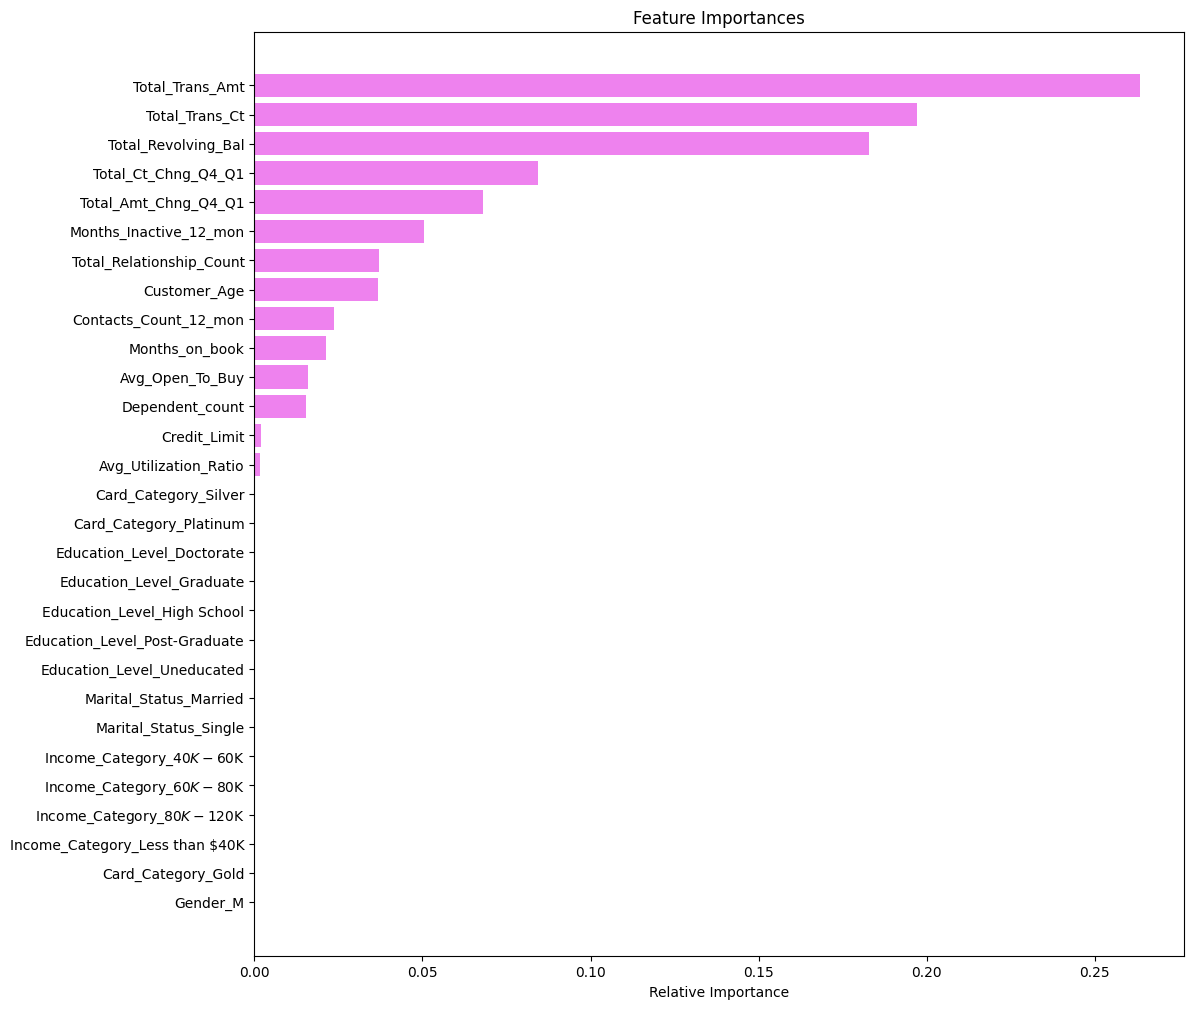

In [554]:
feature_names = X_train.columns
importances = tuned_adb.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

# Business Insights and Conclusions

## Customer Attrition Analysis - Model Insights

### Overview
The model exhibits a Recall Score of 0.969, emphasizing its efficacy in identifying potential customer attrition. The elevated recall score indicates a strong capability to capture instances of attrition.

### Key Predictive Features
The identified significant contributors to predicting customer attrition include:

1. **Total Transaction Amount**
2. **Total Transaction Count**
3. **Total Revolving Balance**
4. **Total Count Change Q4 to Q1**
5. **Total Amount Change Q4 to Q1**
6. **Months Inactive Over 12 months**

### Interpretation and Insights
#### 1. Transaction Behavior:
   - **Total Transaction Amount and Count:** Lower transaction amounts and counts correlate with a higher likelihood of attrition, suggesting a potential link between reduced transactional engagement and attrition.

#### 2. Revolving Balance:
   - **Total Revolving Balance:** Higher revolving balances are associated with increased attrition risk, emphasizing the importance of managing revolving balances for customer retention.

#### 3. Transaction Trends:
   - **Total Count Change Q4 to Q1 and Total Amount Change Q4 to Q1:** Significant changes in transaction counts and amounts from Q4 to Q1 indicate potential attrition. Addressing these changes is crucial for customer retention.

#### 4. Customer Inactivity:
   - **Months Inactive Over 12 months:** Prolonged inactivity significantly contributes to attrition risk. Initiating efforts to re-engage inactive customers is recommended.

### Recommendations
Considering these insights, the following actions are proposed for customer retention:

1. **Proactive Engagement:**
   - Identify customers with lower transactional activity and implement targeted engagement strategies, such as personalized promotions.

2. **Revolving Balance Management:**
   - Implement measures to educate and assist customers in managing their revolving balances to improve satisfaction.

3. **Monitoring Transaction Trends:**
   - Regularly monitor changes in transaction counts and amounts, especially during the Q4 to Q1 transition. Implement retention initiatives for customers displaying significant changes.

4. **Customer Outreach:**
   - Reach out to customers with extended inactivity to understand their needs and concerns, tailoring communication and offers to rekindle engagement.

### Continuous Improvement
While the model provides a foundation for predicting attrition, ongoing refinement and adaptation are essential. Regular updates will ensure effectiveness in a dynamic financial landscape.

In summary, implementing these insights can contribute to reducing customer attrition to maintain competitiveness in the market.


***

# <a name="eda_appendix"></a>Appendix (Exploratory Data Analysis)

In [555]:
# Make another copy of the original data for EDA
eda_df = churn_df.copy()

**CLIENTNUM is a unique customer identifier and will be dropped during data pre-processing. As a result, we will not be using it in Univariate or Bivariate Analysis.**

## Univariate Analysis

### Attrition_Flag           
  

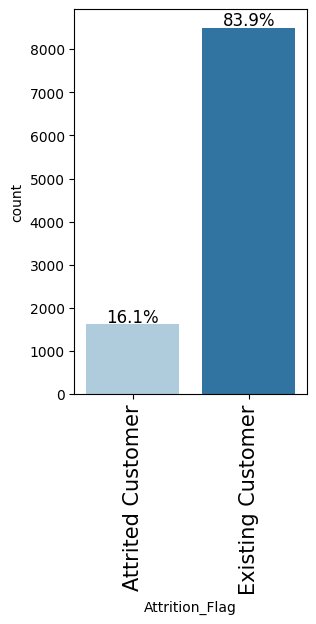

In [556]:
labeled_barplot(eda_df,"Attrition_Flag", perc=True)

#### Observations
* Within the sample data 16% of rows contain a customer which has attritioned and 84% of rows are from existing customers.
* Since this is the dependent variable under or over sampling may be considered.

### Customer_Age             


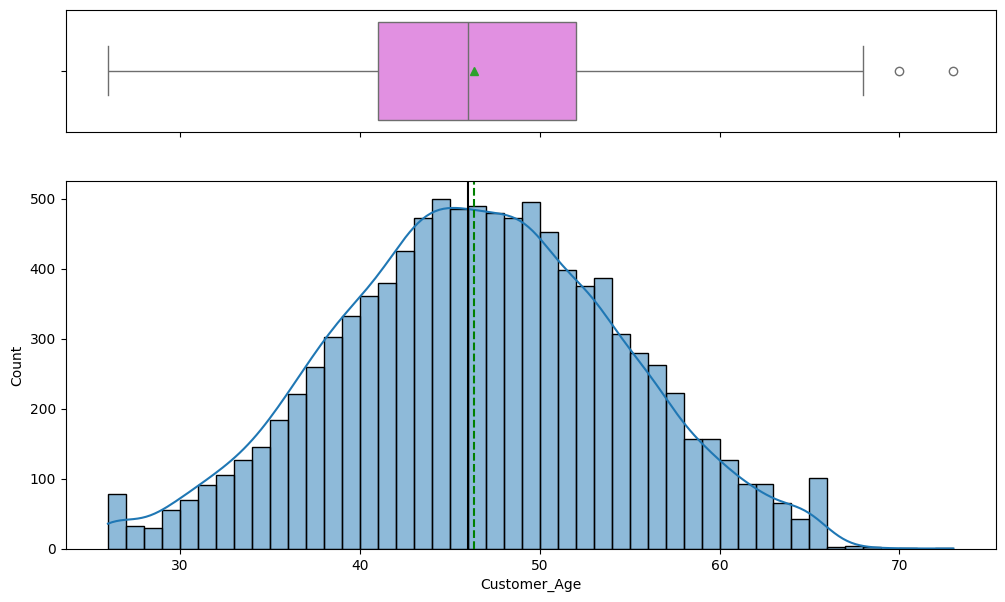

In [557]:
histogram_boxplot(eda_df, "Customer_Age", kde=True)

#### Observations
* The age of the customer data is essentially symmetric.
* The median age is 46 and the mean is about 46.2.
* The youngest customer is 26 and the oldest is in their 70s.

### Gender                   


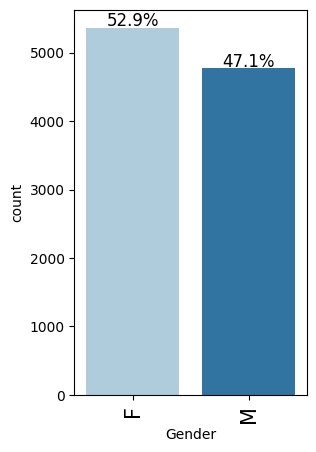

In [558]:
labeled_barplot(eda_df,"Gender", perc=True)

#### Observations
* Slightly more females than males have or have had a credit card.

### Dependent_count          


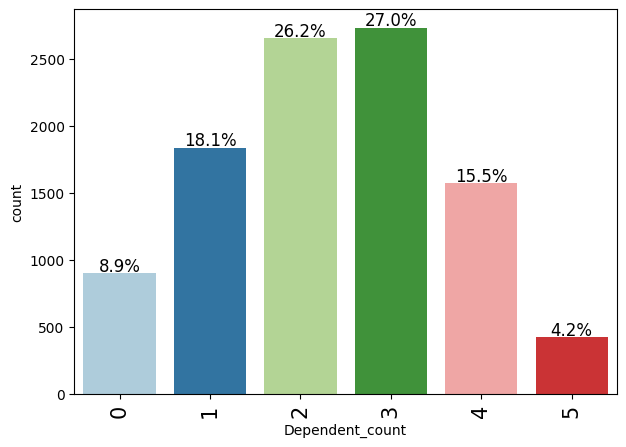

In [559]:
labeled_barplot(eda_df,"Dependent_count", perc=True)

#### Observations
* 53% of customers have two or three dependents.
* 27% of customers have one or no dependents.
* 20% of customers have four or five dependents.

### Education_Level          


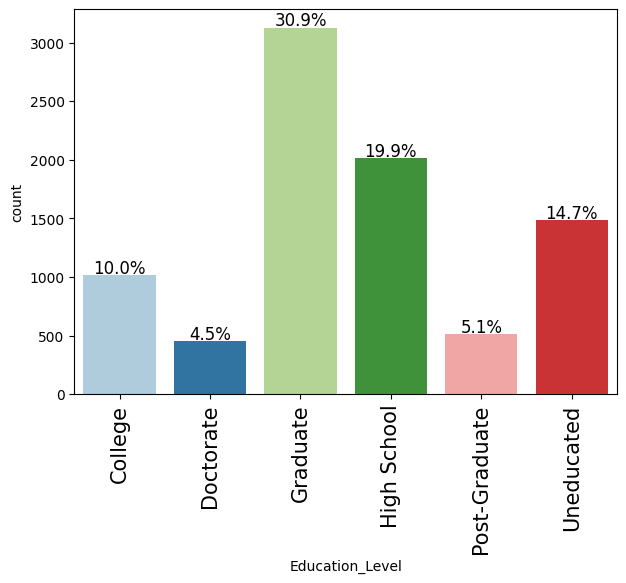

In [560]:
labeled_barplot(eda_df,"Education_Level", perc=True)

#### Observations
* 50% of customers are either college graduates or high school (graduate is assumed).
* 30% of customers are college graduates showing the need for credit after college.

### Marital_Status           


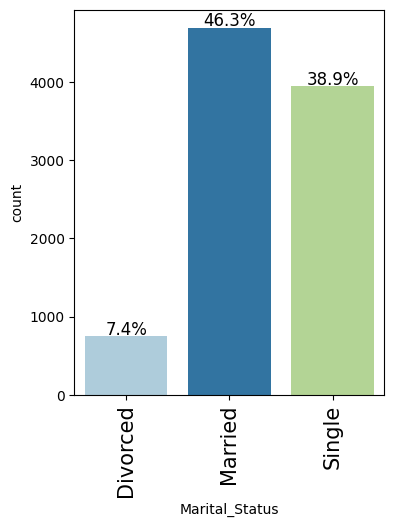

In [561]:
labeled_barplot(eda_df,"Marital_Status", perc=True)

#### Observations
* Married customers beat out single customers 43% to 39%.

### Income_Category          


In [562]:
eda_df['Income_Category'] = eda_df['Income_Category'].replace('abc', 'UNKNOWN')

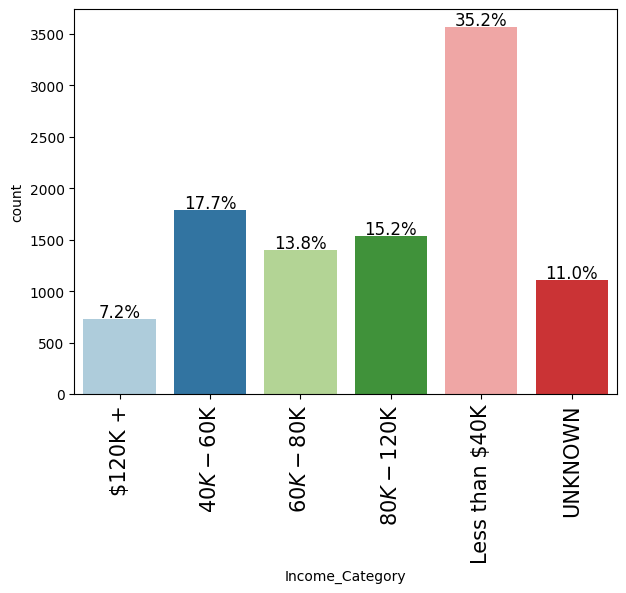

In [563]:
labeled_barplot(eda_df,"Income_Category", perc=True)

#### Observations
* Most customers with credit have an income under 60k per year.
* There are customers whose income is unknown.

### Card_Category            


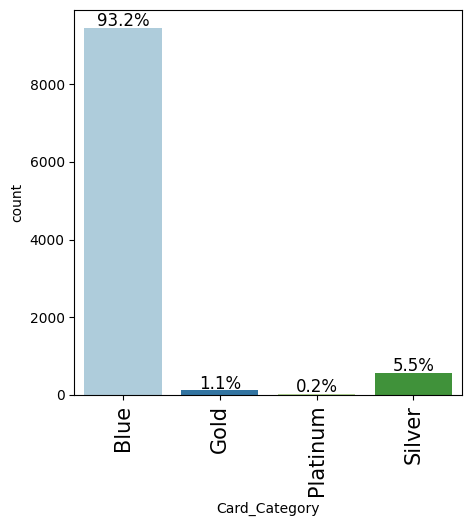

In [564]:
labeled_barplot(eda_df,"Card_Category", perc=True)

#### Observations
* Over 93% of customers own the Blue credit card.

### Months_on_book           


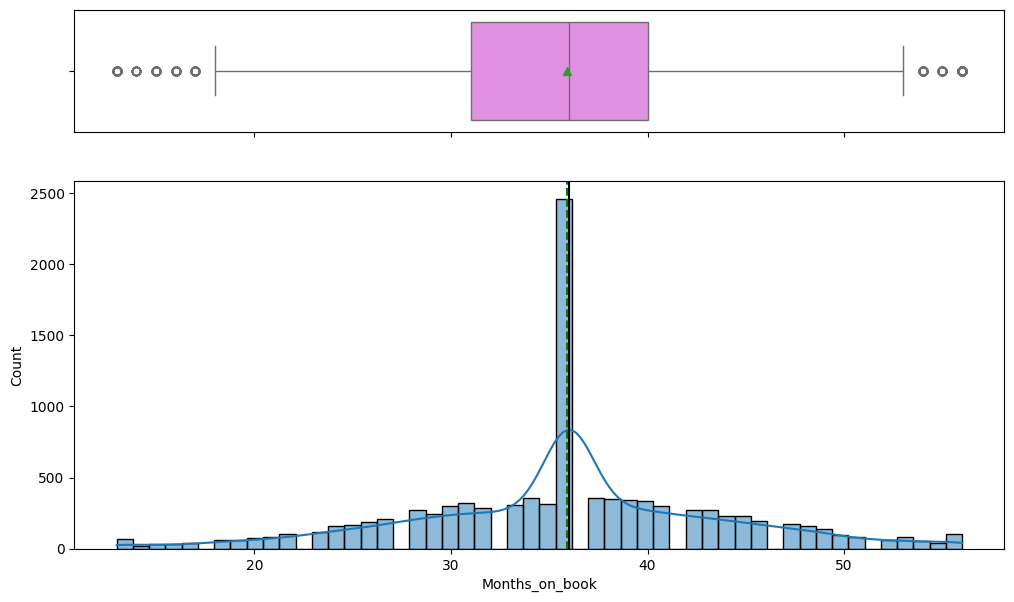

In [565]:
histogram_boxplot(eda_df, "Months_on_book", kde=True)

#### Observations
* There is a large spike of customers who have had a relationship with the bank for 36 month. I would attribute this to opening the bank, but there are also customer who have had a relationship with the bank for over 50 months.
* Data is symmetrical.

### Total_Relationship_Count


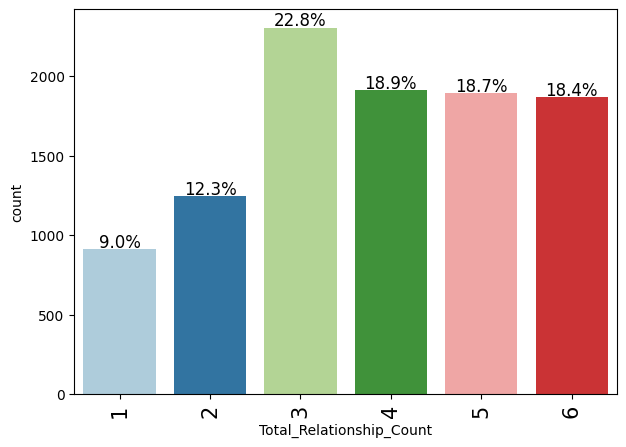

In [566]:
labeled_barplot(eda_df,"Total_Relationship_Count", perc=True)

#### Observations
* 79% of customers have three or more products with the bank.

### Months_Inactive_12_mon   


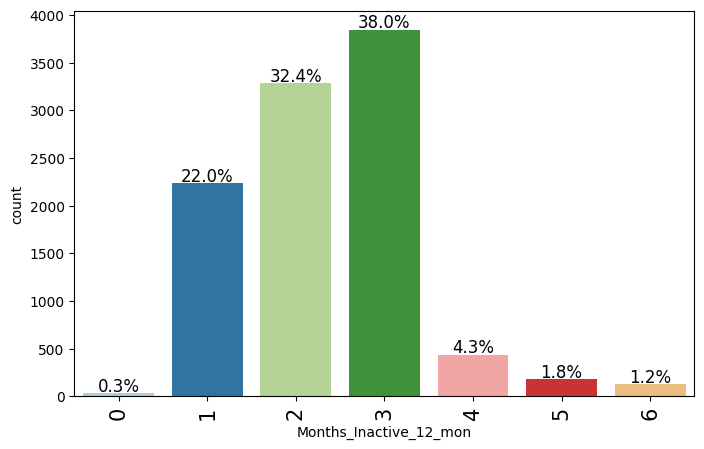

In [567]:
labeled_barplot(eda_df,"Months_Inactive_12_mon", perc=True)

#### Observations
* Only about 7% of customers have been inactive for four or more months.
* I would have expected this chart to have data for all twelve months, but it looks like perhaps the sample of data might be for the last six months.

### Contacts_Count_12_mon    


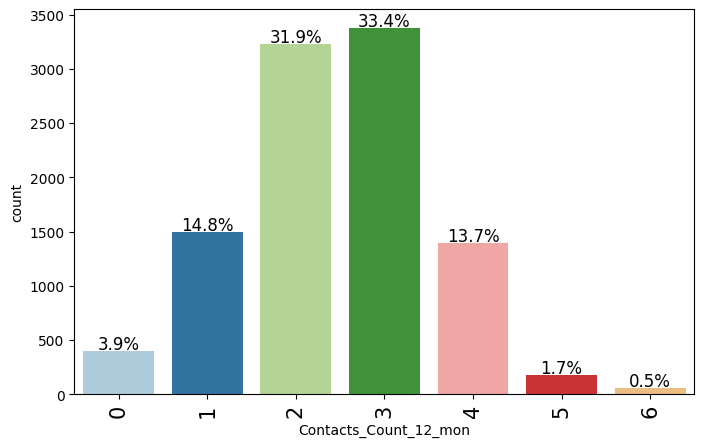

In [568]:
labeled_barplot(eda_df,"Contacts_Count_12_mon", perc=True)

#### Observations
* Assuming this is the bank reaching out to the customer. Most customers have had two or three contacts in the last 12 months.

### Credit_Limit             


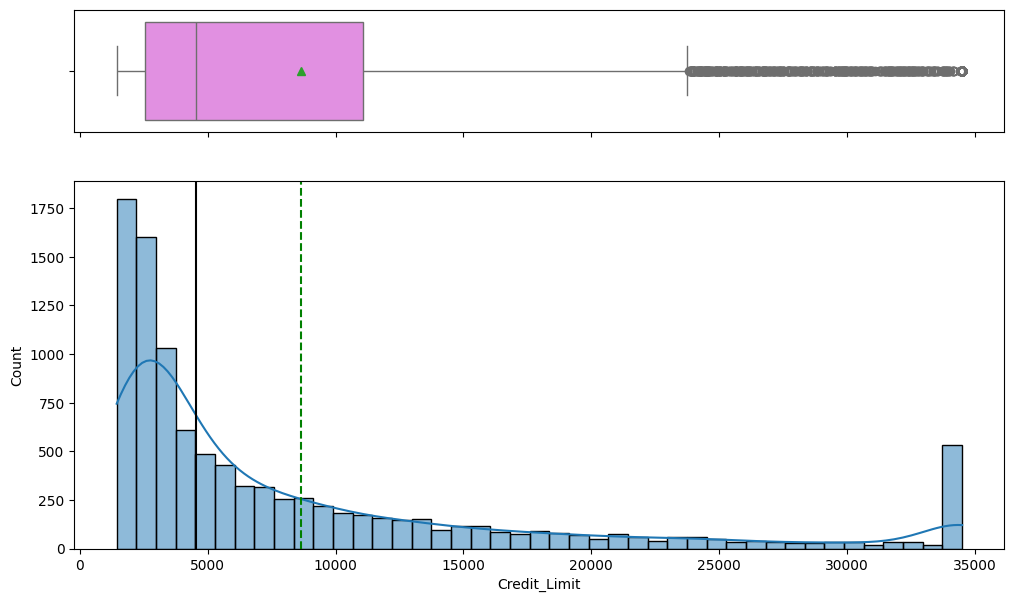

In [569]:
histogram_boxplot(eda_df, "Credit_Limit", kde=True)

#### Observations
* Data is right-skewed with a lot of outliers.
* Most customers have a credit limit of around $8,000.

### Total_Revolving_Bal      


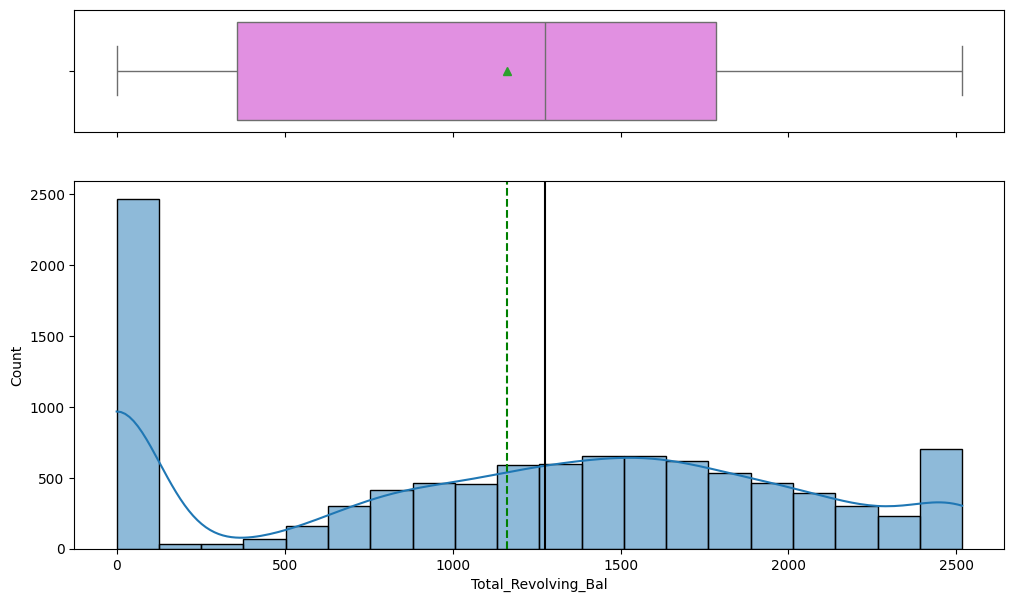

In [570]:
histogram_boxplot(eda_df, "Total_Revolving_Bal", kde=True)

#### Observations
* Data is left skewed.
* Most customers have a revolving balance of around $1,200 dollars.

### Avg_Open_To_Buy          


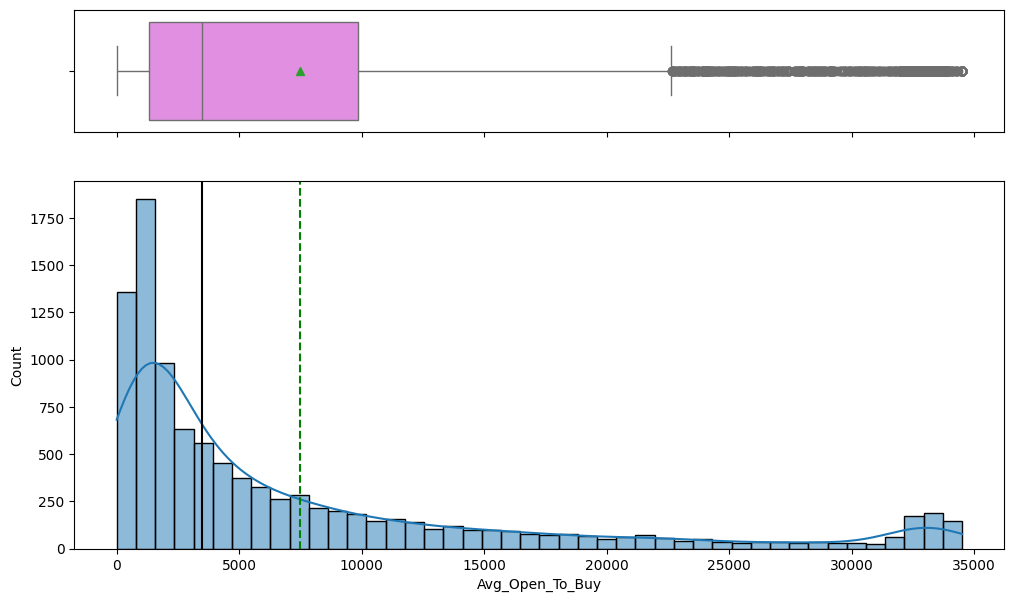

In [571]:
histogram_boxplot(eda_df, "Avg_Open_To_Buy", kde=True)

#### Observations
* 50% of customers have \$7,500 or less remaining on their credit card balance and 50% of customer have more than \$7,500 available.
* The data is right-skewed.

### Total_Amt_Chng_Q4_Q1     


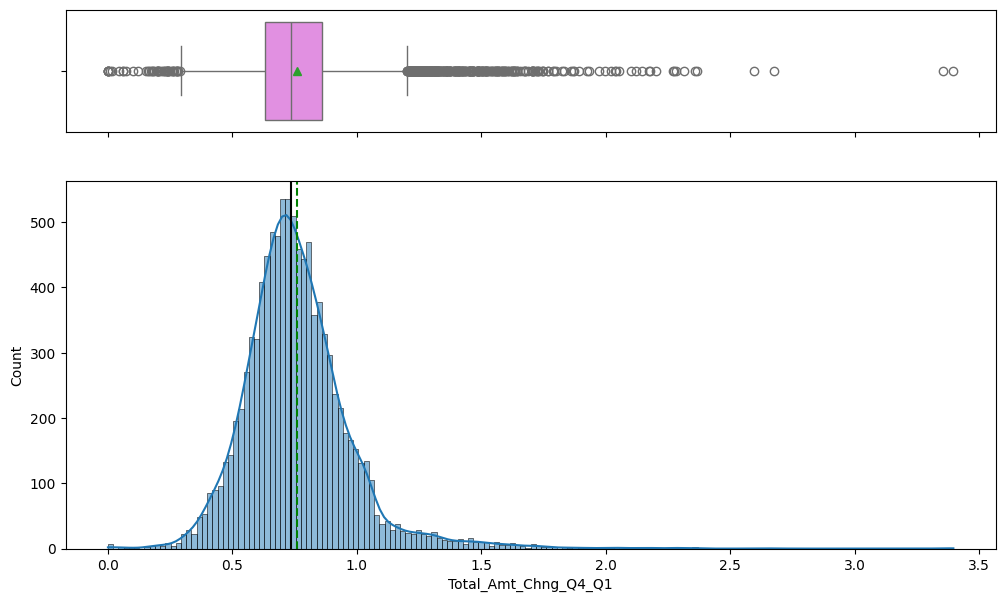

In [572]:
histogram_boxplot(eda_df, "Total_Amt_Chng_Q4_Q1", kde=True)

#### Observations
* Data is slightly skewed to the right.
* There are a lot of outliers to the positive.
* Data looks like it is from two quarters which is six months.
* I may be reading the data incorrectly, but it looks like any number below 1 is a reduction in credit balance. So 50% of people have reduced their credit by about 25% which is where the mean lies. I would need a better understanding of what this value means to come to a better conclusion.

### Total_Trans_Amt          


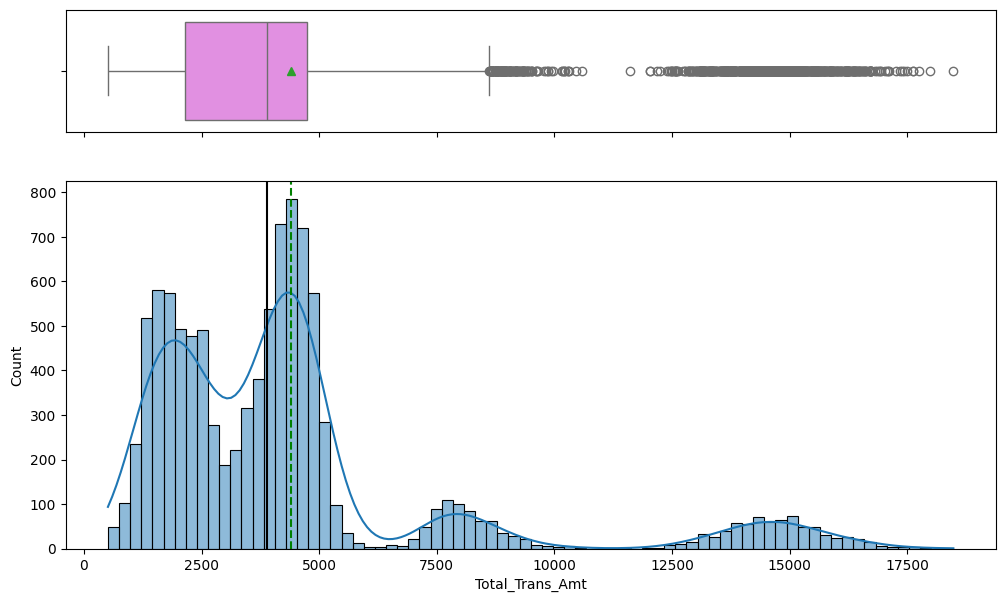

In [573]:
histogram_boxplot(eda_df, "Total_Trans_Amt", kde=True)

#### Observations
* Data is multi-modal.
* Data is right-skewed.
* The majority of customers have a credit card transaction amount of less than $5,000.

### Total_Trans_Ct           

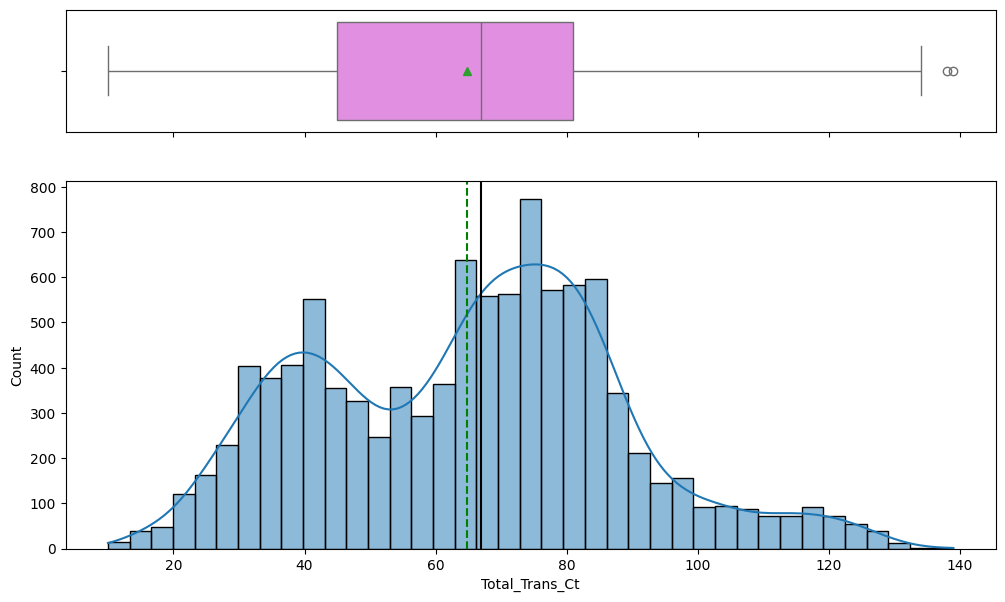

In [574]:
histogram_boxplot(eda_df, "Total_Trans_Ct", kde=True)

#### Observations
* Data is multi-modal.
* Average number of transaction for a customer is about 63.

### Total_Ct_Chng_Q4_Q1      


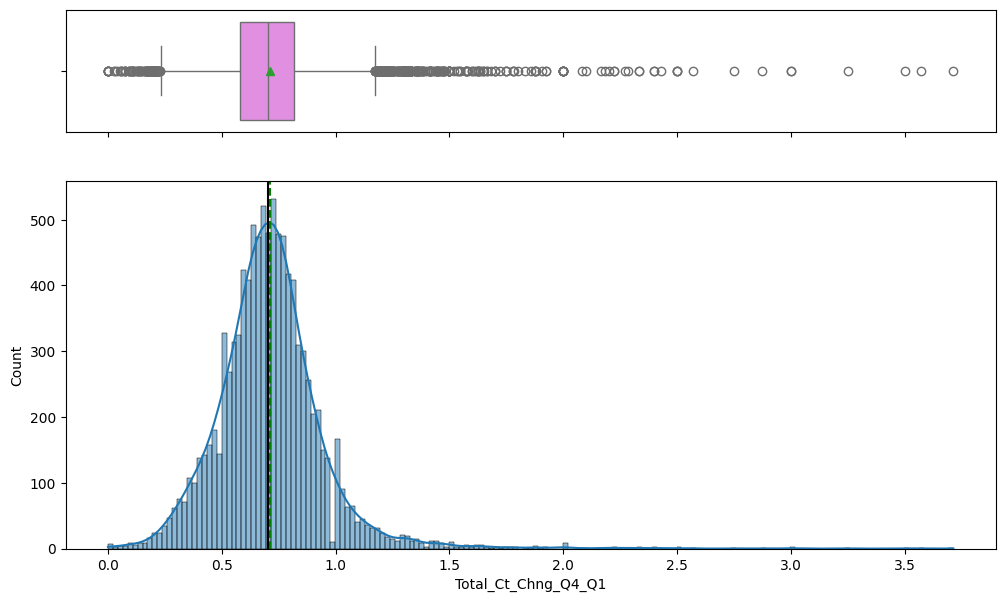

In [575]:
histogram_boxplot(eda_df, "Total_Ct_Chng_Q4_Q1", kde=True)

#### Observations
* Data is symmetric.
* Total transaction could has dropped by 25%. I assuming 1.0 means not change in the number of transactions as I would have expected values below zero as I do not believe it is possible that every customer could have increased their total transaction count.

### Avg_Utilization_Ratio

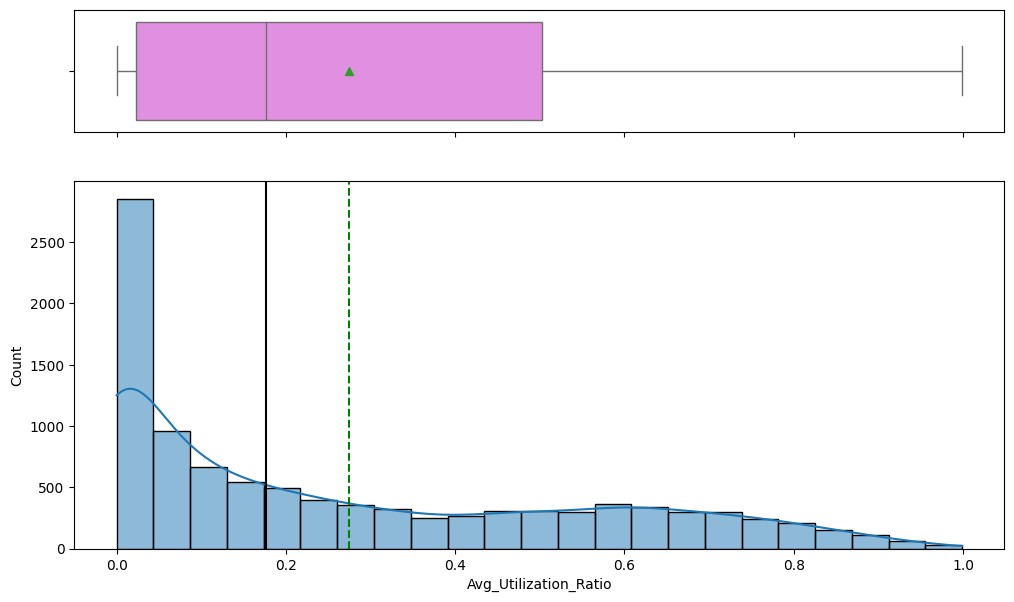

In [576]:
histogram_boxplot(eda_df, "Avg_Utilization_Ratio", kde=True)

#### Observations
* Card utilizatio is the sum of all your balances divided by your credit limit.
* 50% of customer have a utilization ratio of approximately .28 and 50% of customers are over .28.

## Bivariate Analysis

### Heat Map Correlation

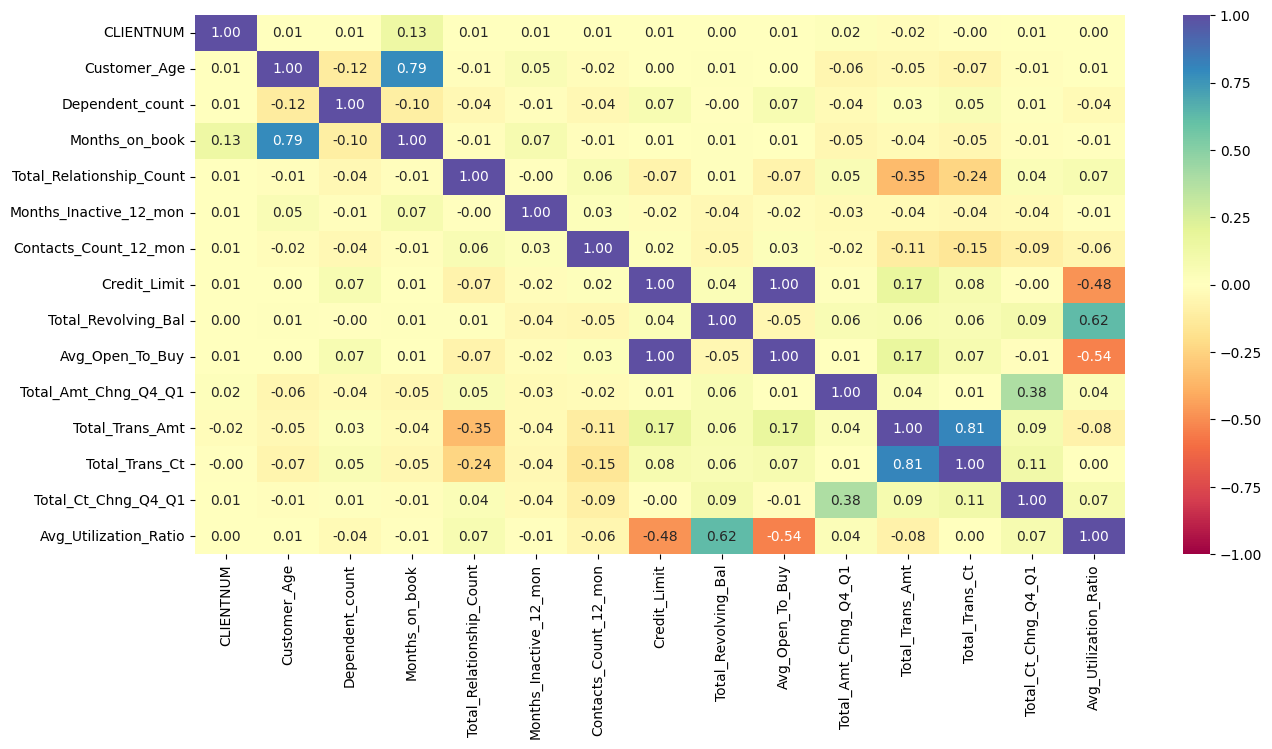

In [577]:
plt.figure(figsize=(15, 7))
sns.heatmap(eda_df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

#### Observations
* Postive Correlations
  * High positive correlations:
    * Customer_Age and Months_on_book
      * As a customer ages they have a longer relationship with the bank.
    * Total_Revolving_Balance and Avg_Utilization_Rate
      * As a customer utilizes their credit card more their balance rises.
    * Total_Trans_Ct and Total_Trans_Amt
      * As a customer performs more transaction with their card their balance rises.
  * Moderate positive correlation
    * Total_Amt_Chng_Q4_Q1 and Total_Ct_Change_Q4_Q1
      * The the count of transactions increased so did a customer's balance amount.
  * Weak positive correlation
    * Total_Trans_Amt and Avg_Open_To_Buy
      * As a customer gets more credit their amount of transactions increase.
  
* Negative Correlations
  * High Negative Correlation
    * Credit_Limit and Avg_Utilization_Ratio
      * As a customer's credit limit increases their utilization decreases.
  * Moderate Negative Correlation
    * Total_Relationship_Count and Total_Trans_Amt
      * As the number of products a customer has increases the total transaction amount decreases.
    * Total_Relationship_Count and Total_Trans_Cnt
      * As the number of products a customer has increases the total transaction count decreases.

### Attrition_Flag and Customer_Age             


Attrition_Flag  Attrited Customer  Existing Customer    All
Customer_Age                                               
All                          1627               8500  10127
43                             85                388    473
48                             85                387    472
44                             84                416    500
46                             82                408    490
45                             79                407    486
49                             79                416    495
47                             76                403    479
41                             76                303    379
50                             71                381    452
54                             69                238    307
40                             64                297    361
42                             62                364    426
53                             59                328    387
52                             58       

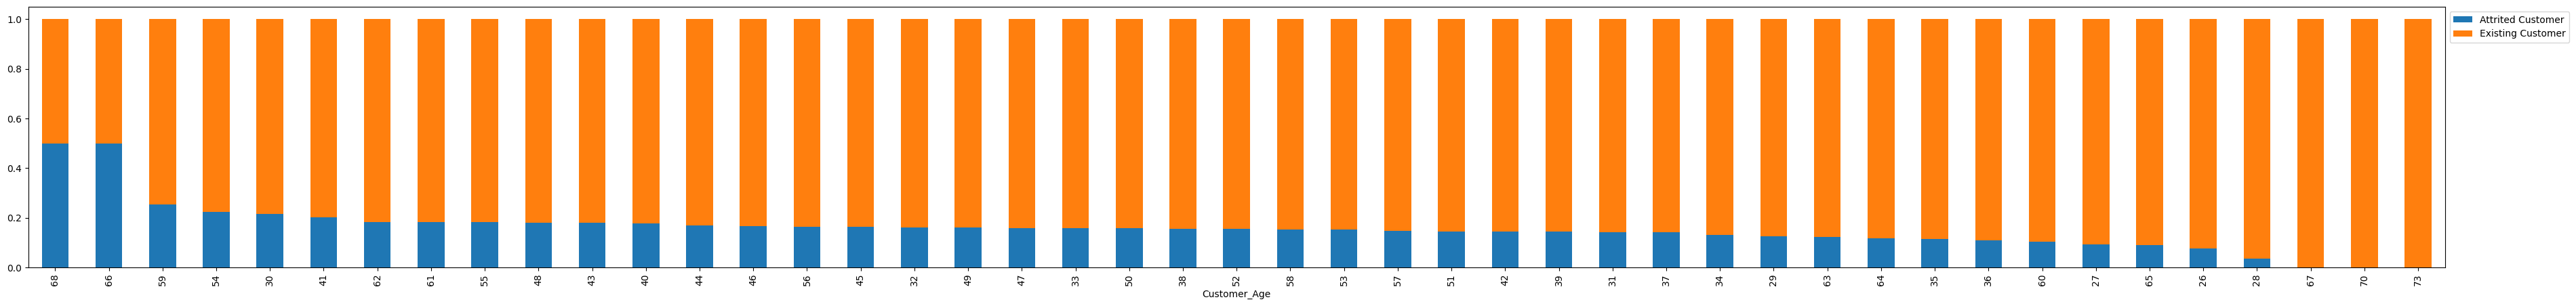

In [578]:
stacked_barplot(eda_df, "Customer_Age", "Attrition_Flag")

#### Observations
* Customers which have attritioned the most are in their 40s.
* Overall customers which attritioned are betwen 30 and 50 years of age.

### Attrition_Flag and Gender                   


Attrition_Flag  Attrited Customer  Existing Customer    All
Gender                                                     
All                          1627               8500  10127
F                             930               4428   5358
M                             697               4072   4769
------------------------------------------------------------------------------------------------------------------------


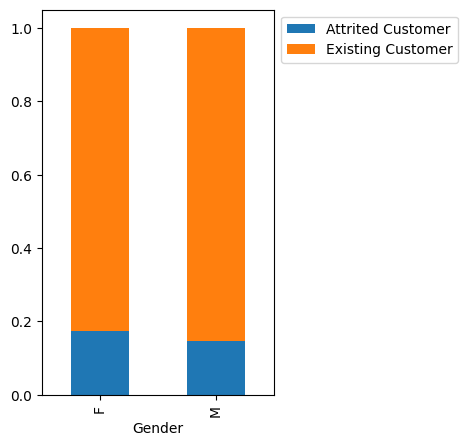

In [579]:
stacked_barplot(eda_df, "Gender", "Attrition_Flag")

#### Observations
* More females have attritioned than males, but there are also more female customers than males.

### Attrition_Flag and Dependent_count          


Attrition_Flag   Attrited Customer  Existing Customer    All
Dependent_count                                             
All                           1627               8500  10127
3                              482               2250   2732
2                              417               2238   2655
1                              269               1569   1838
4                              260               1314   1574
0                              135                769    904
5                               64                360    424
------------------------------------------------------------------------------------------------------------------------


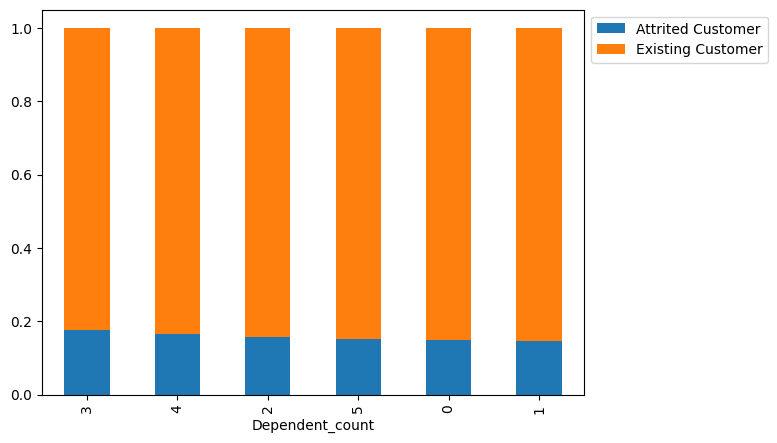

In [580]:
stacked_barplot(eda_df, "Dependent_count", "Attrition_Flag")

#### Observations
* Customers with 2 or 3 dependents have attritioned the most.

### Attrition_Flag and Education_Level          


Attrition_Flag   Attrited Customer  Existing Customer   All
Education_Level                                            
All                           1371               7237  8608
Graduate                       487               2641  3128
High School                    306               1707  2013
Uneducated                     237               1250  1487
College                        154                859  1013
Doctorate                       95                356   451
Post-Graduate                   92                424   516
------------------------------------------------------------------------------------------------------------------------


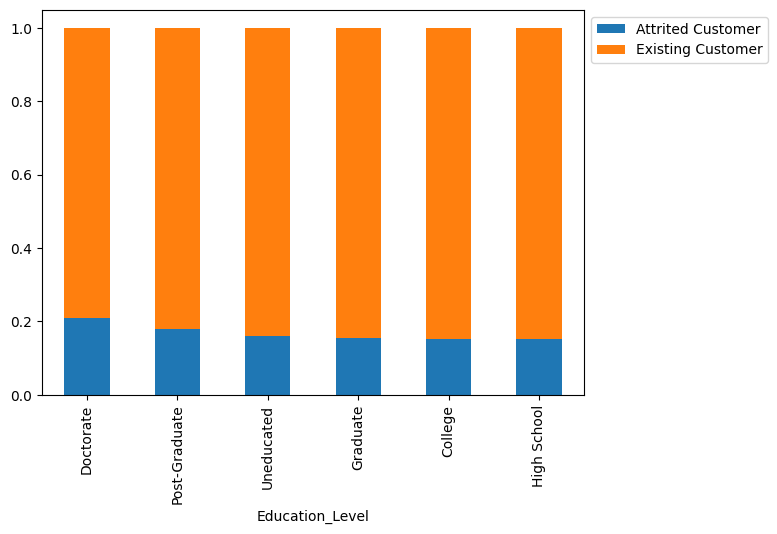

In [581]:
stacked_barplot(eda_df, "Education_Level", "Attrition_Flag")

#### Observations
* College student, Post-Graduate and Doctorate customers have attritioned the least.
* People out of college have attritioned the most.

### Attrition_Flag and Marital_Status           


Attrition_Flag  Attrited Customer  Existing Customer   All
Marital_Status                                            
All                          1498               7880  9378
Married                       709               3978  4687
Single                        668               3275  3943
Divorced                      121                627   748
------------------------------------------------------------------------------------------------------------------------


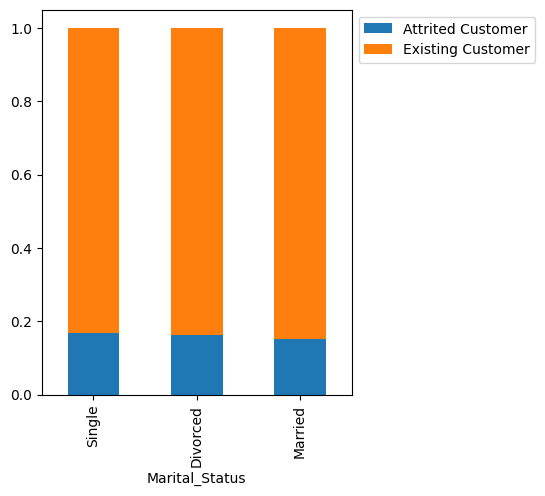

In [582]:
stacked_barplot(eda_df, "Marital_Status", "Attrition_Flag")

#### Observations
* Single, Married and Divorced customers appear to have attritioned at the same rate.

### Attrition_Flag and Income_Category          


In [583]:
eda_df['Income_Category'] = eda_df['Income_Category'].replace('abc', 'UNKNOWN')

Attrition_Flag   Attrited Customer  Existing Customer    All
Income_Category                                             
All                           1627               8500  10127
Less than $40K                 612               2949   3561
$40K - $60K                    271               1519   1790
$80K - $120K                   242               1293   1535
$60K - $80K                    189               1213   1402
UNKNOWN                        187                925   1112
$120K +                        126                601    727
------------------------------------------------------------------------------------------------------------------------


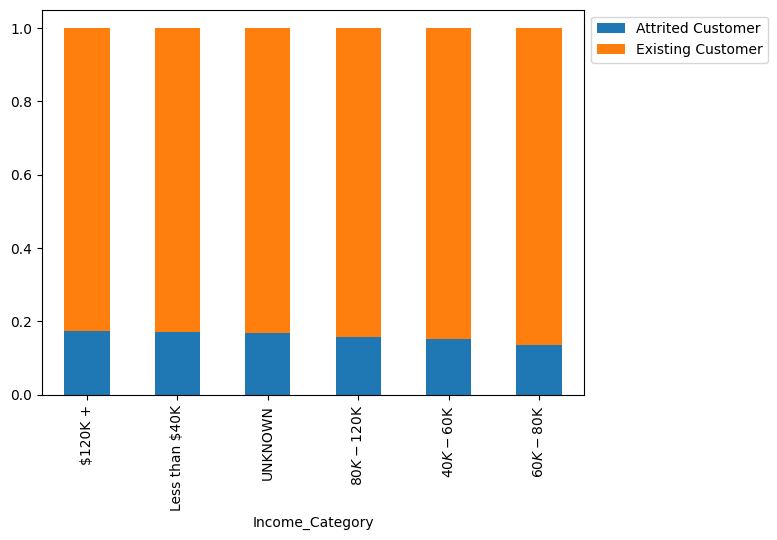

In [584]:
stacked_barplot(eda_df, "Income_Category", "Attrition_Flag")

#### Observations
* Customers making less than 60k per year attritioned the most.

### Attrition_Flag and Card_Category            


Attrition_Flag  Attrited Customer  Existing Customer    All
Card_Category                                              
All                          1627               8500  10127
Blue                         1519               7917   9436
Silver                         82                473    555
Gold                           21                 95    116
Platinum                        5                 15     20
------------------------------------------------------------------------------------------------------------------------


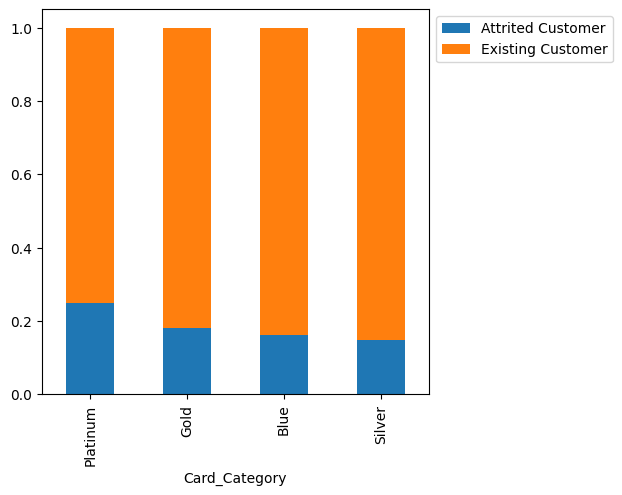

In [585]:
stacked_barplot(eda_df, "Card_Category", "Attrition_Flag")

#### Observations
* Blue card holders are the largest group (over 90%) so it makes sense that they have attritioned the most.



### Attrition_Flag and Months_on_book           


Attrition_Flag  Attrited Customer  Existing Customer    All
Months_on_book                                             
All                          1627               8500  10127
36                            430               2033   2463
39                             64                277    341
37                             62                296    358
30                             58                242    300
38                             57                290    347
34                             57                296    353
41                             51                246    297
33                             48                257    305
40                             45                288    333
35                             45                272    317
32                             44                245    289
28                             43                232    275
44                             42                188    230
43                             42       

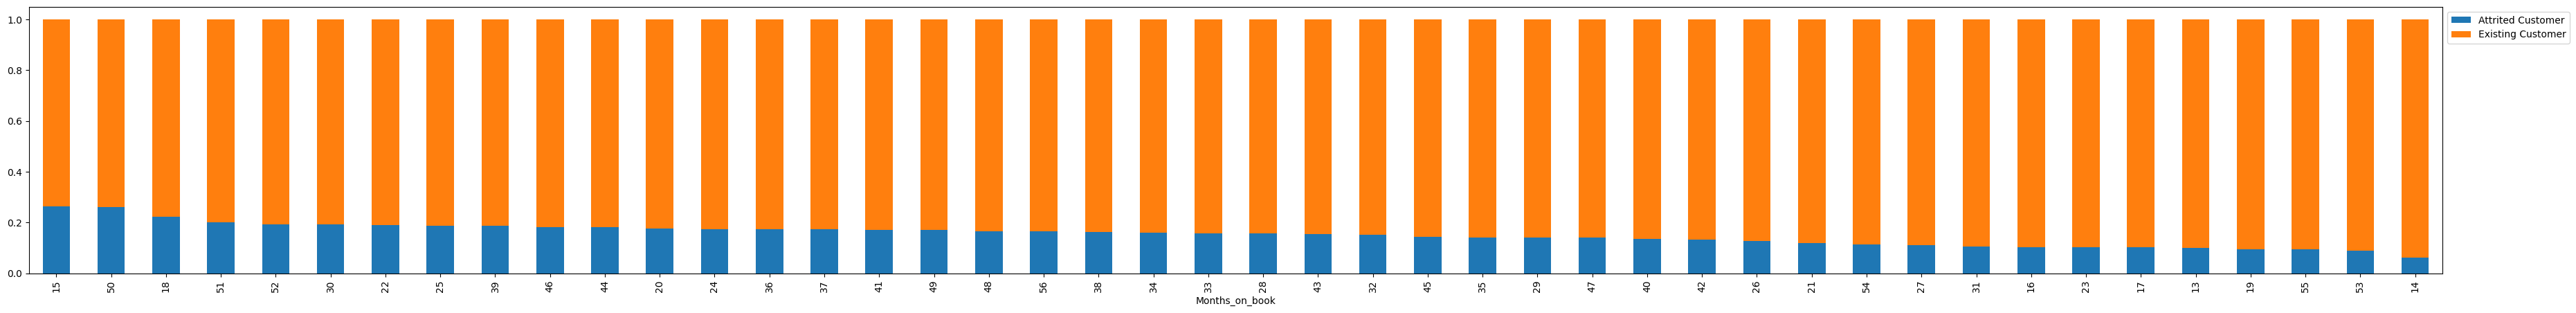

In [586]:
stacked_barplot(eda_df, "Months_on_book", "Attrition_Flag")

#### Observations
* For some reason, at 36 months is when most people attritioned from the bank. More context is needed, but it looks like people in their 30s and 40s have attritioned from the bank the most.

### Attrition_Flag and Total_Relationship_Count


Attrition_Flag            Attrited Customer  Existing Customer    All
Total_Relationship_Count                                             
All                                    1627               8500  10127
3                                       400               1905   2305
2                                       346                897   1243
1                                       233                677    910
5                                       227               1664   1891
4                                       225               1687   1912
6                                       196               1670   1866
------------------------------------------------------------------------------------------------------------------------


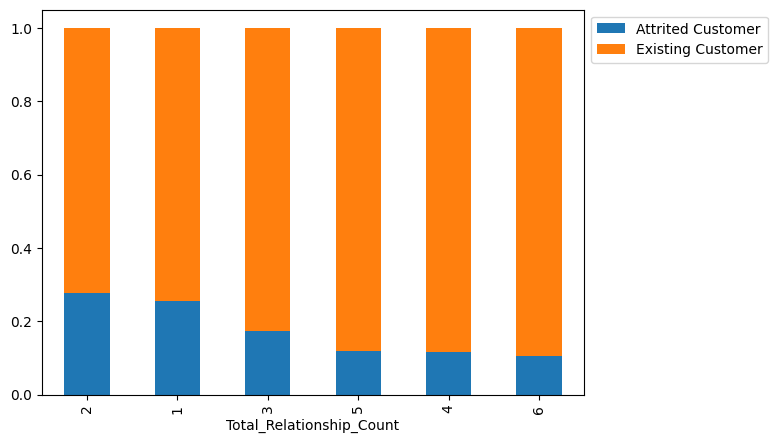

In [587]:
stacked_barplot(eda_df, "Total_Relationship_Count", "Attrition_Flag")

#### Observations
* Customers with only 1 or 2 products with the bank attritioned more than customers with 3 or more products.

### Attrition_Flag and Months_Inactive_12_mon   


Attrition_Flag          Attrited Customer  Existing Customer    All
Months_Inactive_12_mon                                             
All                                  1627               8500  10127
3                                     826               3020   3846
2                                     505               2777   3282
4                                     130                305    435
1                                     100               2133   2233
5                                      32                146    178
6                                      19                105    124
0                                      15                 14     29
------------------------------------------------------------------------------------------------------------------------


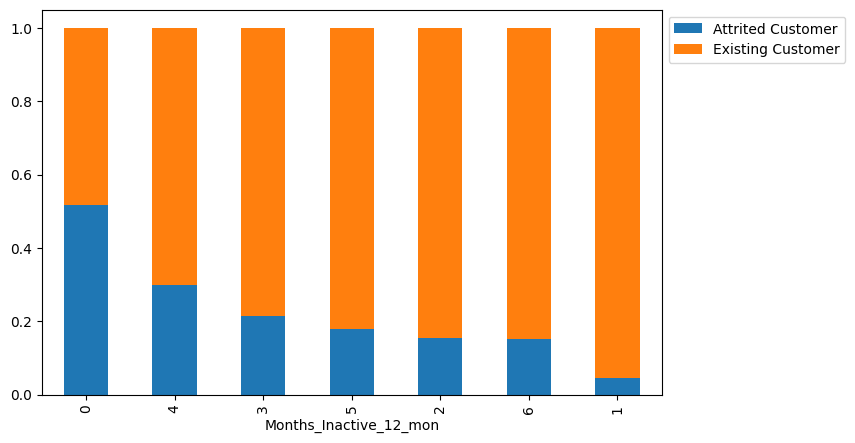

In [588]:
stacked_barplot(eda_df, "Months_Inactive_12_mon", "Attrition_Flag")

#### Observations
* Customers who have been 2 or 3 months inactive have attritioned the most.

### Attrition_Flag and Contacts_Count_12_mon    


Attrition_Flag         Attrited Customer  Existing Customer    All
Contacts_Count_12_mon                                             
All                                 1627               8500  10127
3                                    681               2699   3380
2                                    403               2824   3227
4                                    315               1077   1392
1                                    108               1391   1499
5                                     59                117    176
6                                     54                  0     54
0                                      7                392    399
------------------------------------------------------------------------------------------------------------------------


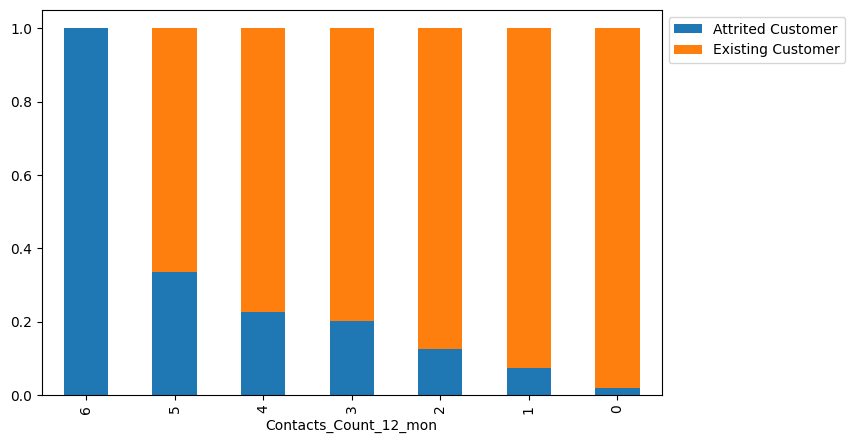

In [589]:
stacked_barplot(eda_df, "Contacts_Count_12_mon", "Attrition_Flag")

#### Observations
* Customers with over 2 contacts have attirtioned the most.
* Do not contact a customer 6 or more times as their attrition rate is 100%.

### Attrition_Flag and Credit_Limit             


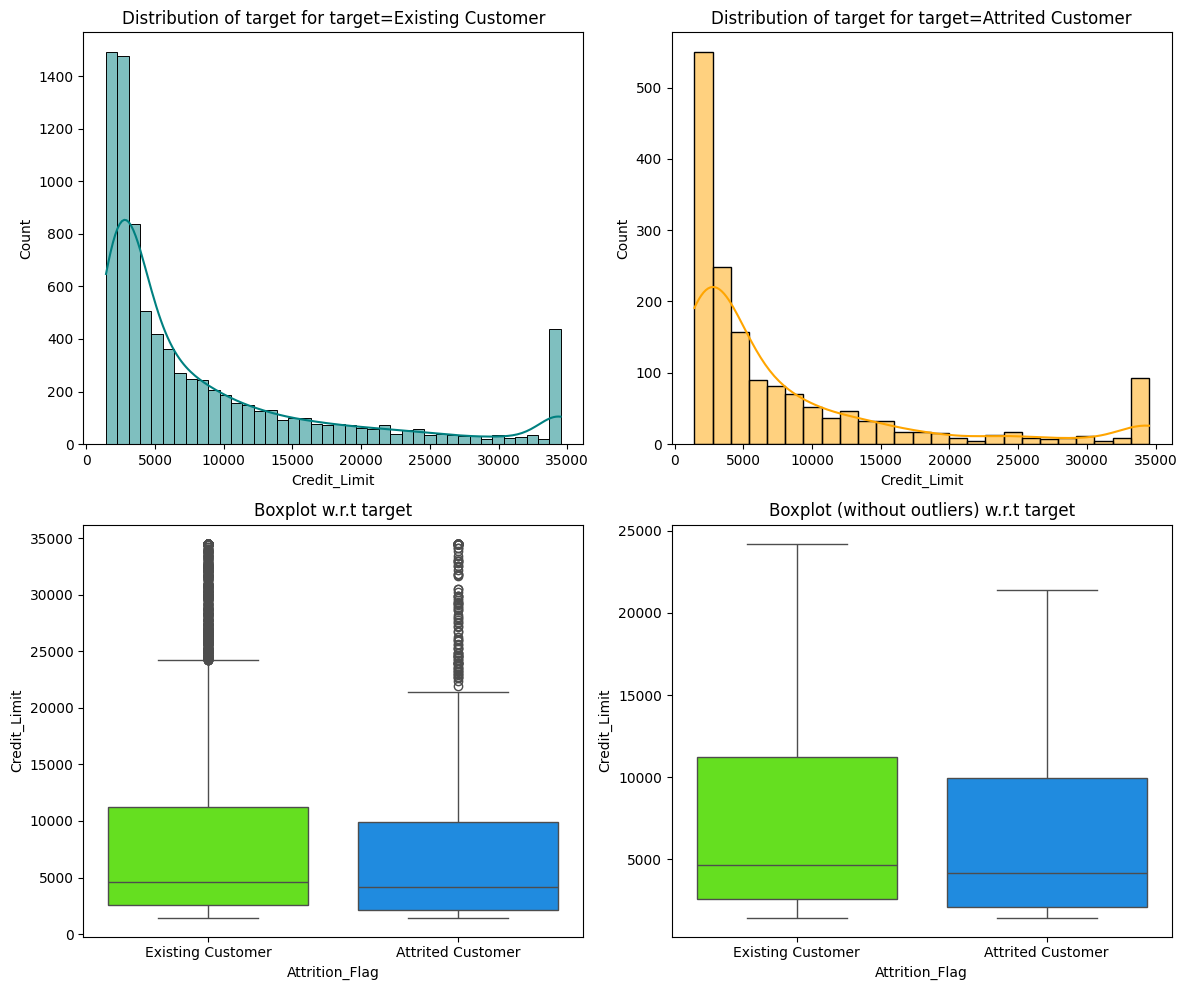

In [590]:
distribution_plot_wrt_target(eda_df, "Credit_Limit", "Attrition_Flag")

#### Observations
* Existing customers carry a slightly larger balance than customers who have left the bank.

### Attrition_Flag and Total_Revolving_Bal      


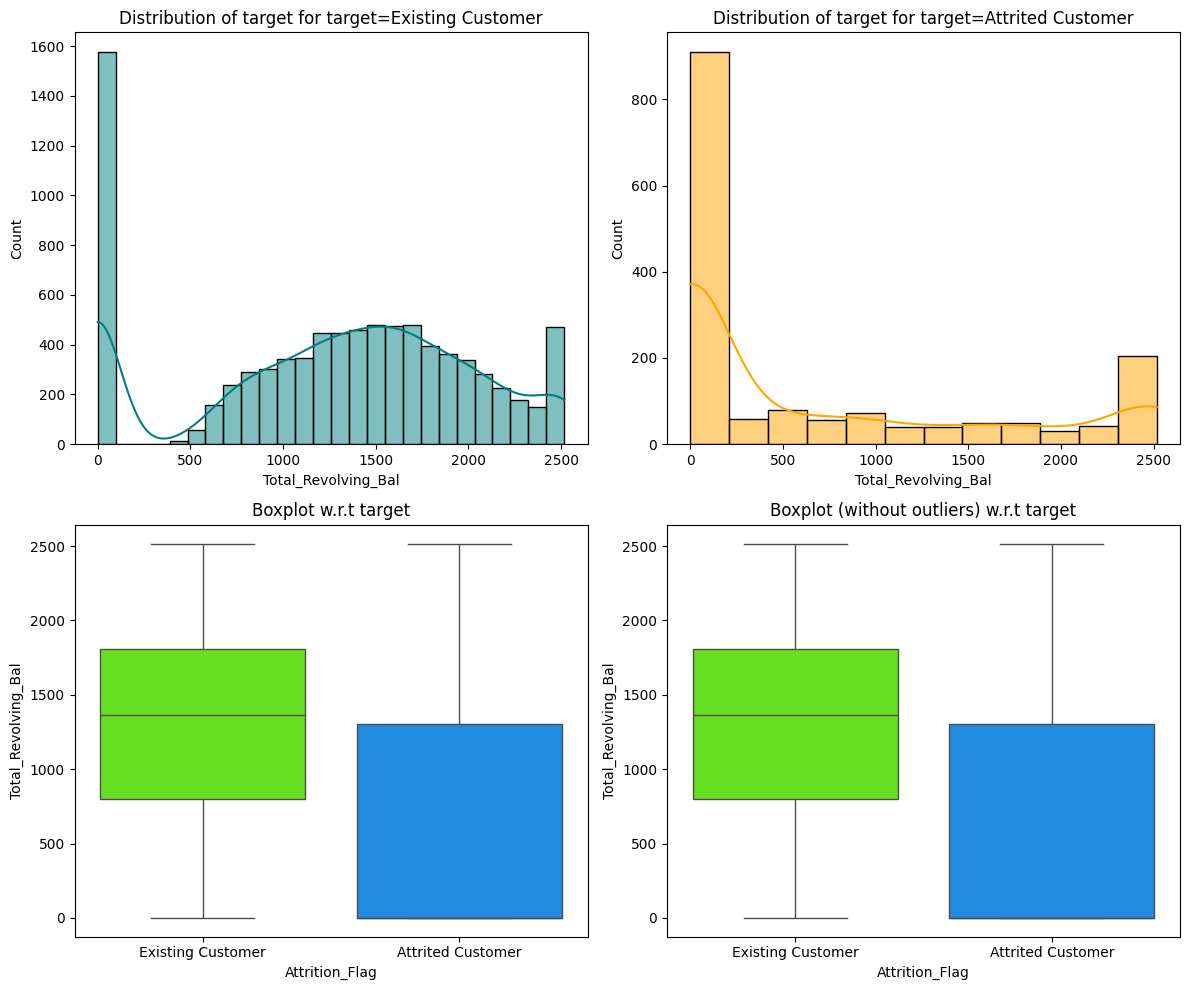

In [591]:
distribution_plot_wrt_target(eda_df, "Total_Revolving_Bal", "Attrition_Flag")

#### Observations
* Existing customer carry a balance between \$1,000 and \$2,000
* Most existing and attrited customers carry a balance of zero.
* Attrited customers are relatively flat with regards to their current balance. \$500 to \$2,000 is all less than 100.

### Attrition_Flag and Avg_Open_To_Buy          


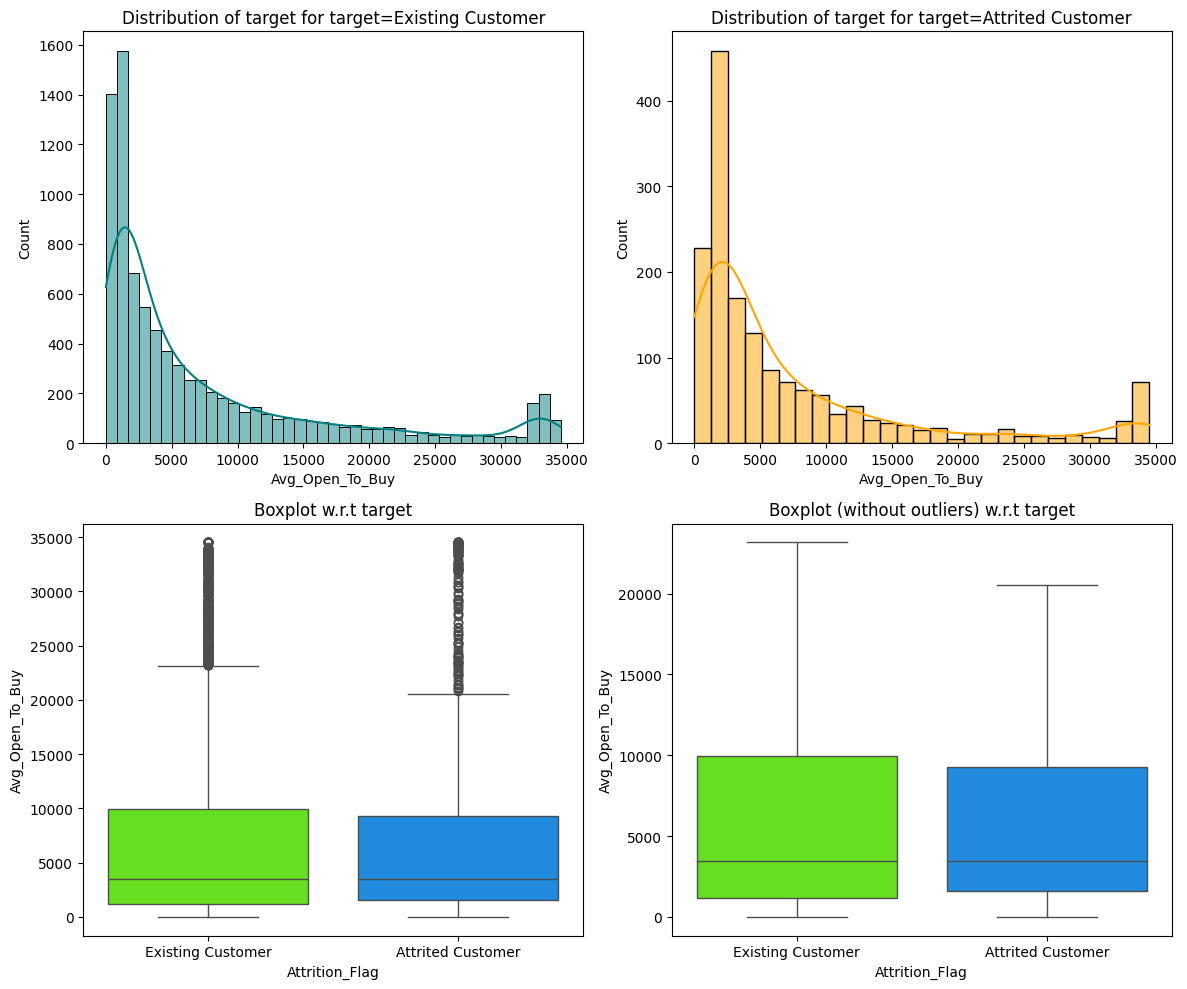

In [592]:
distribution_plot_wrt_target(eda_df, "Avg_Open_To_Buy", "Attrition_Flag")

#### Observations
* Existing and Attrited customer's distribution appears to be the same with regards to Avg_Open_To_Buy.

### Attrition_Flag and Total_Amt_Chng_Q4_Q1     


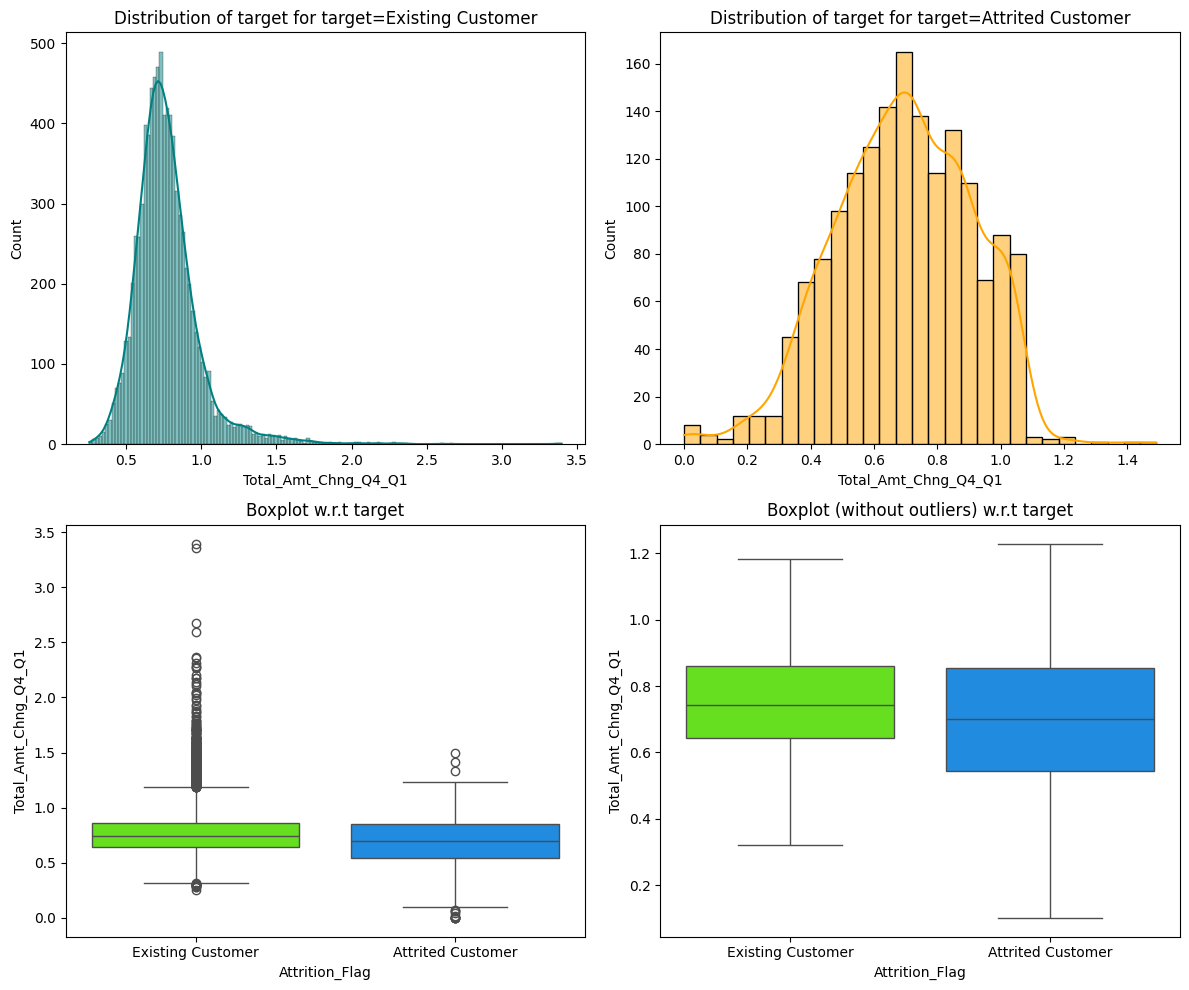

In [593]:
distribution_plot_wrt_target(eda_df, "Total_Amt_Chng_Q4_Q1", "Attrition_Flag")

#### Observations
* Attrited customers and existing customers appear to be reducing their overall balance in Q4 to Q1.

### Attrition_Flag and Total_Trans_Amt          


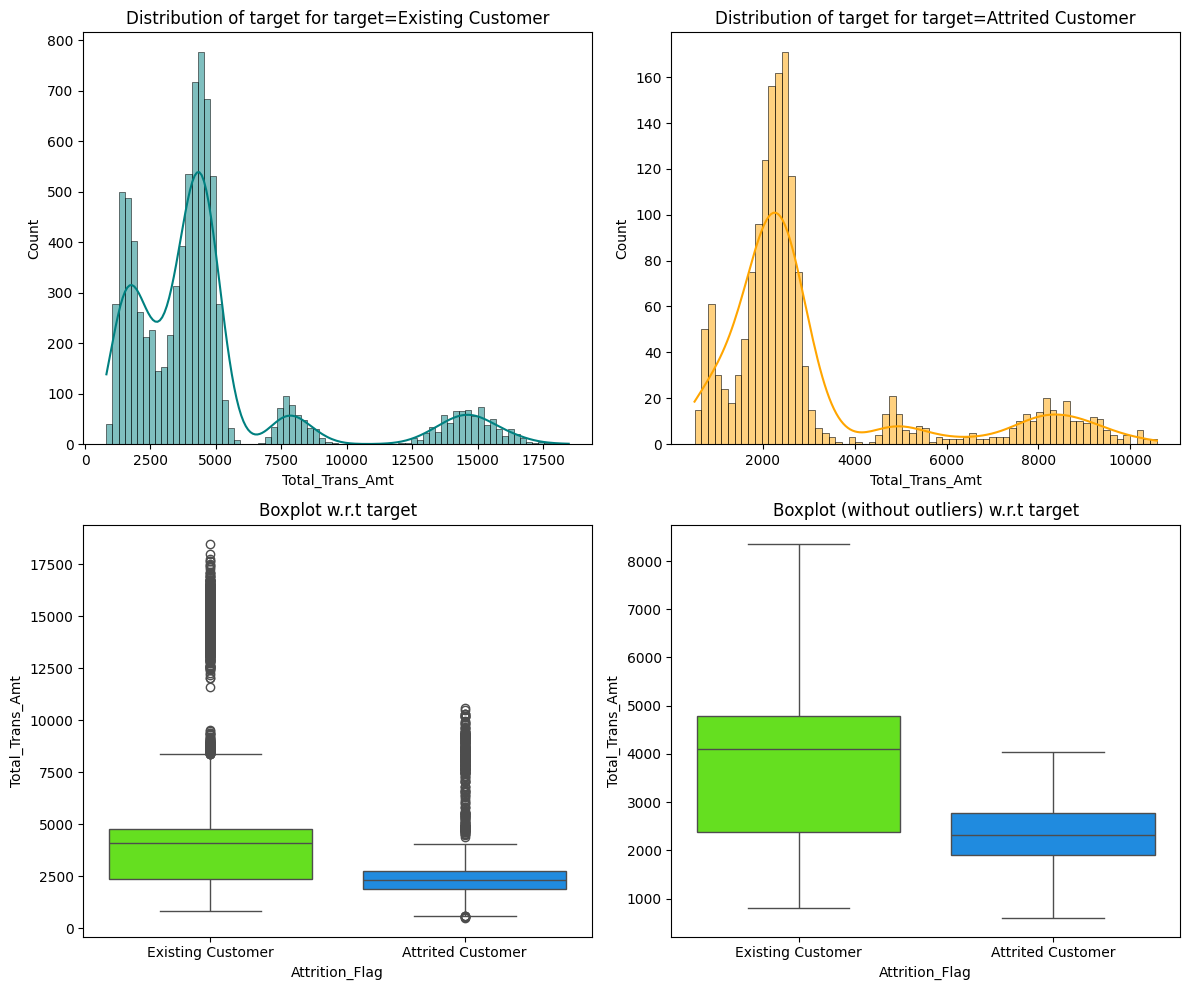

In [594]:
distribution_plot_wrt_target(eda_df, "Total_Trans_Amt", "Attrition_Flag")

#### Observations
* Attrited customers as expect have a lower transaction amount.
* Distribution between existing and attrited customers is the same.

### Attrition_Flag and Total_Trans_Ct           

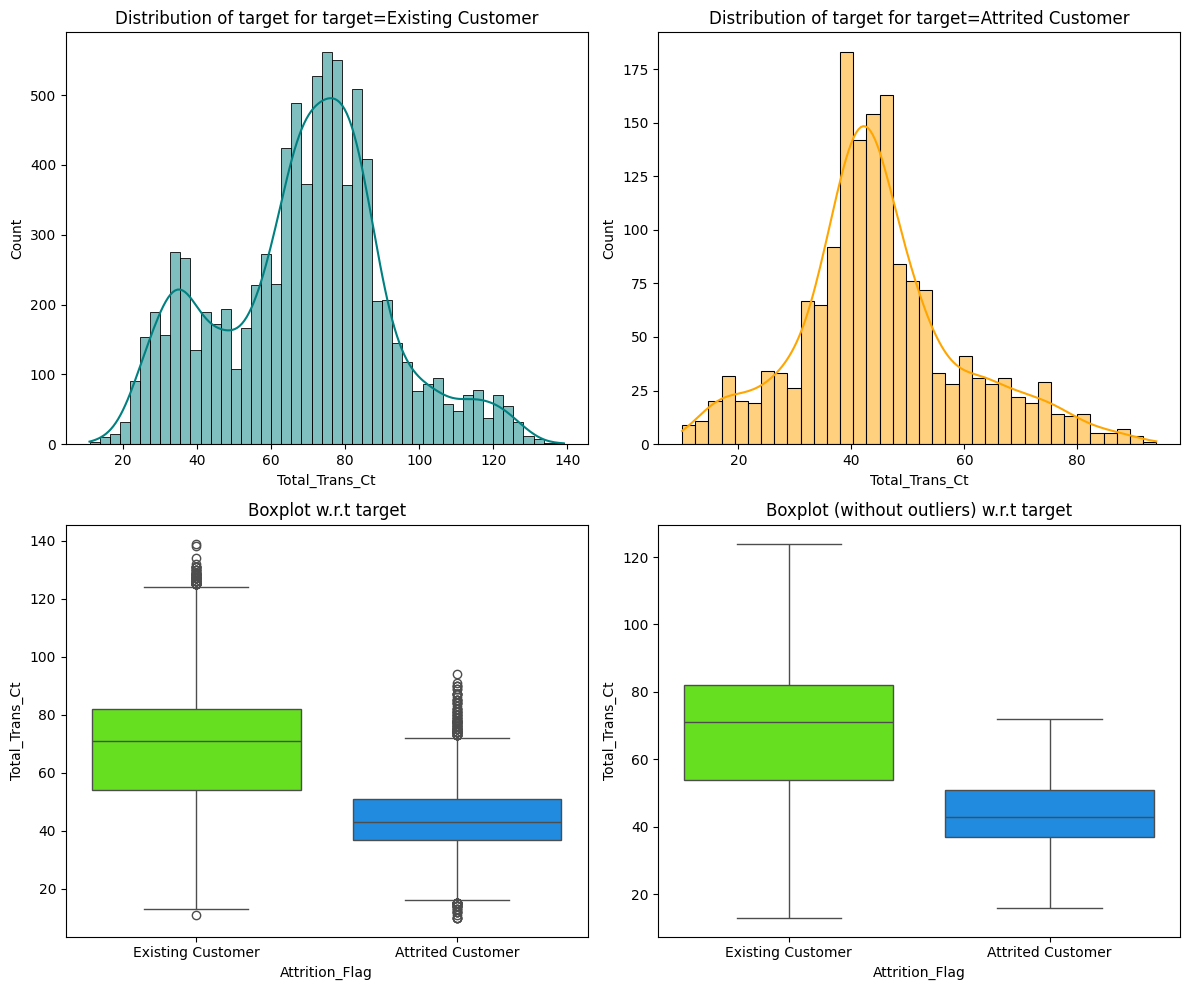

In [595]:
distribution_plot_wrt_target(eda_df, "Total_Trans_Ct", "Attrition_Flag")

#### Observations
* Attrited customers have a lower number or total transactions.
* The distributions between existing and attrited customers appear to be the same.

### Attrition_Flag and Total_Ct_Chng_Q4_Q1      


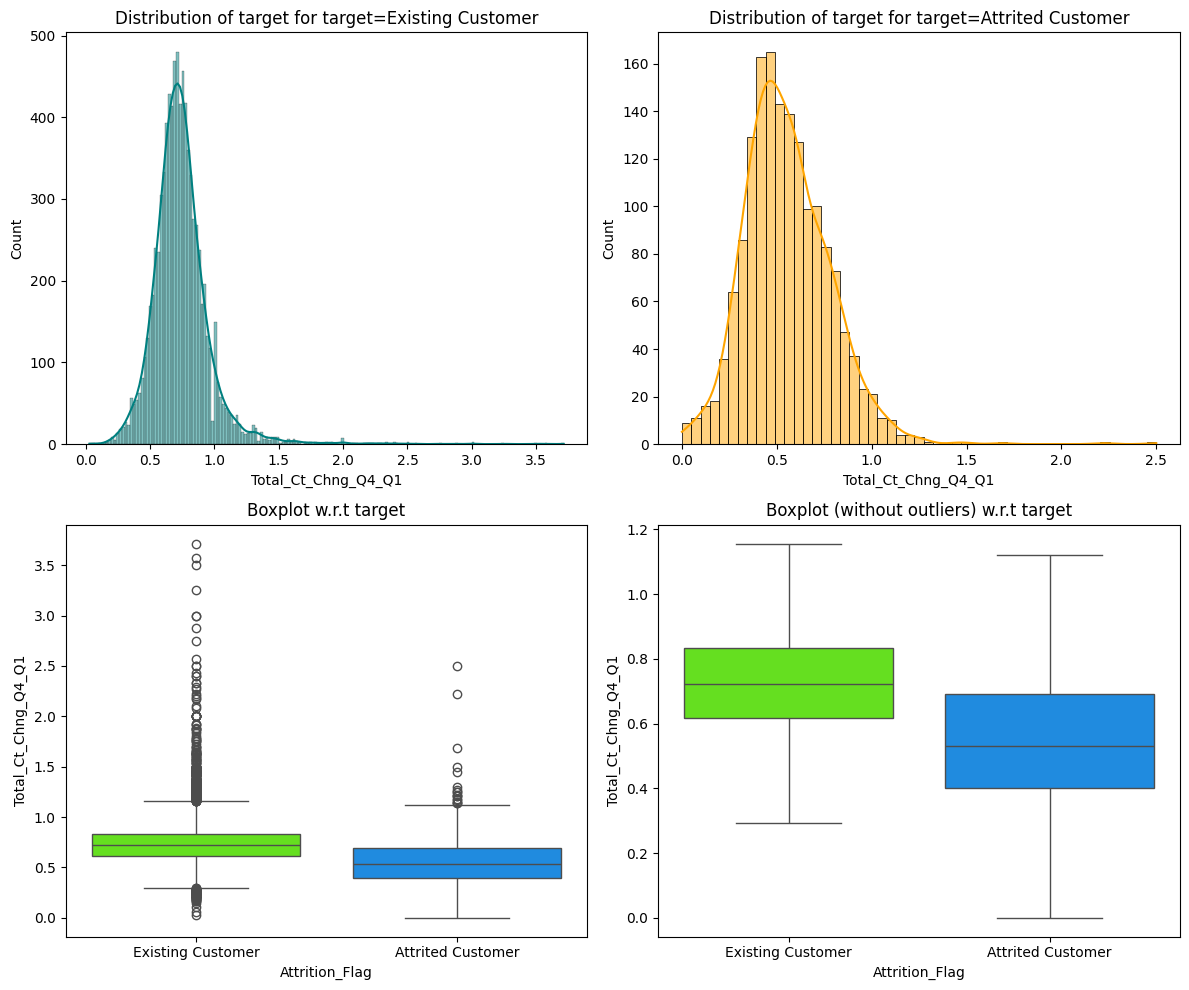

In [596]:
distribution_plot_wrt_target(eda_df, "Total_Ct_Chng_Q4_Q1", "Attrition_Flag")

#### Observations
* Attrited customers have a lower number or Q4 to Q1 transactions.
* The distributions between existing and attrited customers appear to be the same.

### Attrition_Flag and Avg_Utilization_Ratio

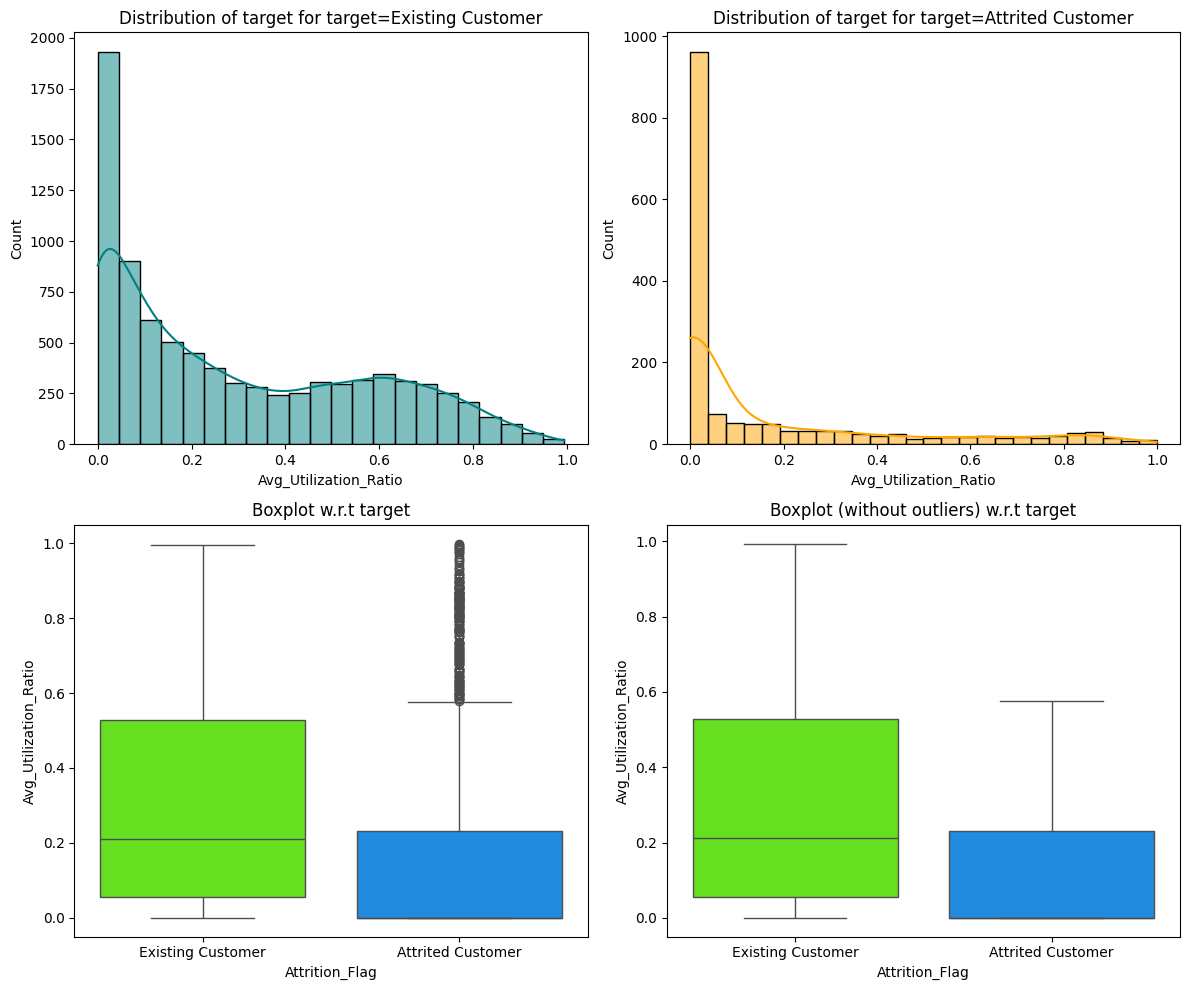

In [597]:
distribution_plot_wrt_target(eda_df, "Avg_Utilization_Ratio", "Attrition_Flag")

#### Observations
* Existing customers use their credit card more than attrited customers.
* Distributions are roughly the same.

## <a href=#eda_summary>Click to get back to the EDA Summary</a>